Keras implementation of combined Conditional VAE and Auxiliary-Classifier GAN.

* The combined VAE-GAN is partially inspired from the paper "Autoencoding beyond pixels using a learned similarity metric" with major modifications.

* Keras tricks to train GAN is ispired from https://github.com/keras-team/keras/issues/8585 and https://github.com/eriklindernoren/Keras-GAN

In [ ]:
# imports
### Disable tensorflow 2.0
%tensorflow_version 1.x
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from __future__ import print_function, division
from builtins import range, input
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Activation, Dropout, Reshape, Add, Multiply, MaxPooling2D, AveragePooling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.losses import mse, binary_crossentropy, categorical_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import plot_model
from keras import backend as K
## added to plot model in google colab
from IPython.display import Image

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import os
from datetime import datetime

import imageio

In [ ]:
import sys
sys.path

['/tensorflow-1.15.2/python3.6',
 '',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
# append path if needed
sys.path.append('/content/drive/My Drive/Colab/GAN/Pytorch')

In [ ]:
# Encoder parameters
img_dim = 64
colors = 3
labels_dim = 3
latent_dim = 8
dec_dim = latent_dim # default equals to latent_dim. (different in case PCA is applied before decoder, not used here)
filter_size = 3

In [ ]:
# General parameters
ALPHA = 1 # to switch from VAE (1) to AE (0)
BETA = 1 # for beta-VAE (weight for KL). Default is 1
ZETA = 1/2 # for combined GAN VAE with MSE loss (weight for MSE)
DELTA = 1 # for the auxiliary classifier at the output of GAN
GAMMA = 1024 # for learned metric (https://arxiv.org/pdf/1512.09300.pdf)
optimizer = Adam(0.0002, 0.5) #RMSprop()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# GAN Discriminator 1
input_disc = Input(shape=(img_dim,img_dim,colors,), name="disc_input")
h_disc = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_1_activated")(input_disc)
h_disc = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="disc_conv_2_no-activation")(h_disc)
h_disc = BatchNormalization(name="disc_batchNorm_1")(h_disc)
h_disc = Activation(activation="relu", name="disc_relu_1")(h_disc)
## new
h_disc = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_3_activated")(h_disc)
h_disc = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="disc_conv_4_activated")(h_disc)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f_disc = Flatten(name="disc_flatten")(h_disc)
## additional dense layer for dimensionality reduction
d_disc = Dense(256, activation ="relu", name="disc_dense_1_mean_activated")(f_disc)
##
out_disc = Dense(1, activation="sigmoid", name="disc_dense_2_std_activated")(d_disc)
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##

discriminator_1 = Model(inputs=input_disc, outputs=out_disc, name="discriminator")

In [ ]:
# GAN Discriminator 3
img = Input(shape=(img_dim,img_dim,colors,), name="D_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Dense 2
D_out = Dense(1, activation='sigmoid', name="D_out")(h)
        
discriminator_3 = Model(img,D_out,name="discriminator")

In [ ]:
# GAN Discriminator 4 (disriminator with auxiliary classifier and learned metric output)
img = Input(shape=(img_dim,img_dim,colors,), name="D_in_metric")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size = filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
h = Flatten()(h)
# Dense 1
h = Dense(1024)(h)
h = BatchNormalization(momentum=0.99)(h)
h_metric = LeakyReLU(alpha=0.2)(h)
discriminator_metric = Model(img,h_metric,name="discriminator_metric")


img_disc = Input(shape=(img_dim,img_dim,colors,), name="D_in")

##  features
metric_disc = discriminator_metric(img_disc)  

# Dense 2
## true/fake
D_out = Dense(1, activation='sigmoid', name="D_out_adv")(metric_disc)
## labels
D_out_labels = Dense(labels_dim, activation='softmax', name="D_out_labels")(metric_disc)
#discriminator_4 = Model(img,[D_out,D_out_labels],name="discriminator")
discriminator_4 = Model(img_disc,concatenate([D_out,D_out_labels,metric_disc]),name="discriminator")

In [ ]:
discriminator = discriminator_4

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

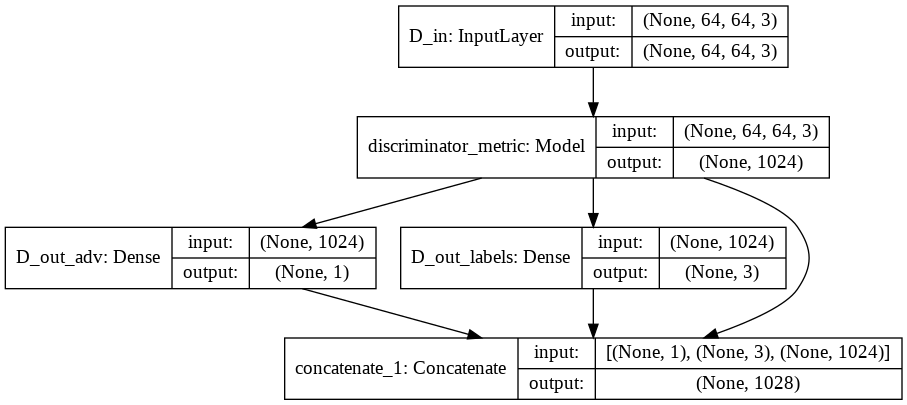

In [ ]:
# summary of the discriminator
discriminator.summary()
# plot model
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='discriminator.png')

In [ ]:
'''
# first method, compile here
# compile descriminator
discriminator.compile(loss='binary_crossentropy',
            optimizer = optimizer,
            metrics=['accuracy'])
'''

"\n# first method, compile here\n# compile descriminator\ndiscriminator.compile(loss='binary_crossentropy',\n            optimizer = optimizer,\n            metrics=['accuracy'])\n"

In [ ]:
# VAE encoder 1
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(input_enc)
h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)
## new
h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)
h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)
#h = Conv2D(filters= 2*latent_dim, kernel_size=4, strides=1, padding='valid', name="enc_conv_5_no-activation")(h) # exactly equivalent to FC
f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d) #only for VAE
##

#f = Flatten(name="enc_flatten")(h)
#d = Dense(100,name="enc_dense_1_no-activation")(f)
#d = BatchNormalization(name="enc_batchNorm_2")(d)
#d = Activation(activation="relu", name="enc_relu_2")(d)
#z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
#z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

## new
#z_mu = Lambda(lambda x : x[:,:latent_dim], name="enc_split_1")(f)
#z_std = Lambda(lambda x : x[:,latent_dim:], name="enc_split_2")(f)
#z_std = Activation(activation="softplus", name="enc_sofplus")(z_std)
##
if ALPHA:
  encoder_1 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_1 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

In [ ]:
# VAE encoder 2 - Inception units
input_enc = Input(shape=(img_dim,img_dim,colors,), name="enc_input")
## inception 1
inc1_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(input_enc)
inc1_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(input_enc)
h = concatenate([inc1_1,inc1_2])

h = Conv2D(filters= 8, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_1_activated")(h)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc2_1,inc2_2])

h = Conv2D(filters= 16, kernel_size=3, strides=2, padding='same', name="enc_conv_2_no-activation")(h)
h = BatchNormalization(name="enc_batchNorm_1")(h)
h = Activation(activation="relu", name="enc_relu_1")(h)

## inception 3
inc3_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc3_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc3_1,inc3_2])

h = Conv2D(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_3_activated")(h)

## inception 4
inc4_1 = Conv2D(filters= 32, kernel_size=1, strides=1, padding='same', activation="relu")(h)
inc4_2 = Conv2D(filters= 32, kernel_size=3, strides=1, padding='same', activation="relu")(h)
h = concatenate([inc4_1,inc4_2])

h = Conv2D(filters= 64, kernel_size=3, strides=2, padding='same', activation="relu", name="enc_conv_4_activated")(h)

f = Flatten(name="enc_flatten")(h)
## additional dense layer for dimensionality reduction
d = Dense(256, activation ="relu", name="enc_dense_1_mean_activated")(f)
##
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_2 = Model(inputs=input_enc, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_2 = Model(inputs=input_enc, outputs=z_mu, name="encoder")

In [ ]:
# encoder 3
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
# Conv from image
h = Conv2D(32, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(128, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
# Dense 1
d = Dense(1024)(f)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_3 = Model(inputs=img, outputs=[z_mu,z_std], name="encoder")
else:
  encoder_3 = Model(inputs=img, outputs=z_mu, name="encoder")

In [ ]:
# encoder 4
img = Input(shape=(img_dim,img_dim,colors,), name="enc_in")
input_enc_labels = Input(shape=(labels_dim,), name="enc_input_labels")
# Conv from image
h = Conv2D(16, kernel_size=1, strides=1, padding="same")(img)
h = LeakyReLU(alpha=0.2)(h)
# Conv 1
h = Conv2D(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 2
h = Conv2D(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Conv 3
h = Conv2D(128, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = LeakyReLU(alpha=0.2)(h)
# Flatten
f = Flatten()(h)
## add labels
f_c = concatenate([f,input_enc_labels])
# Dense 1
d = Dense(1024)(f_c)
d = BatchNormalization(momentum=0.99)(d)
d = LeakyReLU(alpha=0.2)(d)
# Dense 2
z_mu = Dense(latent_dim,name="enc_dense_2_mean_no-activation")(d)
if ALPHA:
  z_std = Dense(latent_dim, activation="softplus", name="enc_dense_2_std_activated")(d)

if ALPHA:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=[z_mu,z_std], name="encoder")
else:
  encoder_4 = Model(inputs=[img,input_enc_labels], outputs=z_mu, name="encoder")

In [ ]:
encoder = encoder_4

In [ ]:
encoder.output_shape

[(None, 8), (None, 8)]

In [ ]:
# track the dimension before and after flattening
dim_pre_flatten = h._keras_shape[1:]
dim_post_flatten  = f._keras_shape[1]
print(dim_pre_flatten,dim_post_flatten)

(8, 8, 128) 8192


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_in (InputLayer)             (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 16)   64          enc_in[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_6 (LeakyReLU)       (None, 64, 64, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   4640        leaky_re_lu_6[0][0]              
____________________________________________________________________________________________

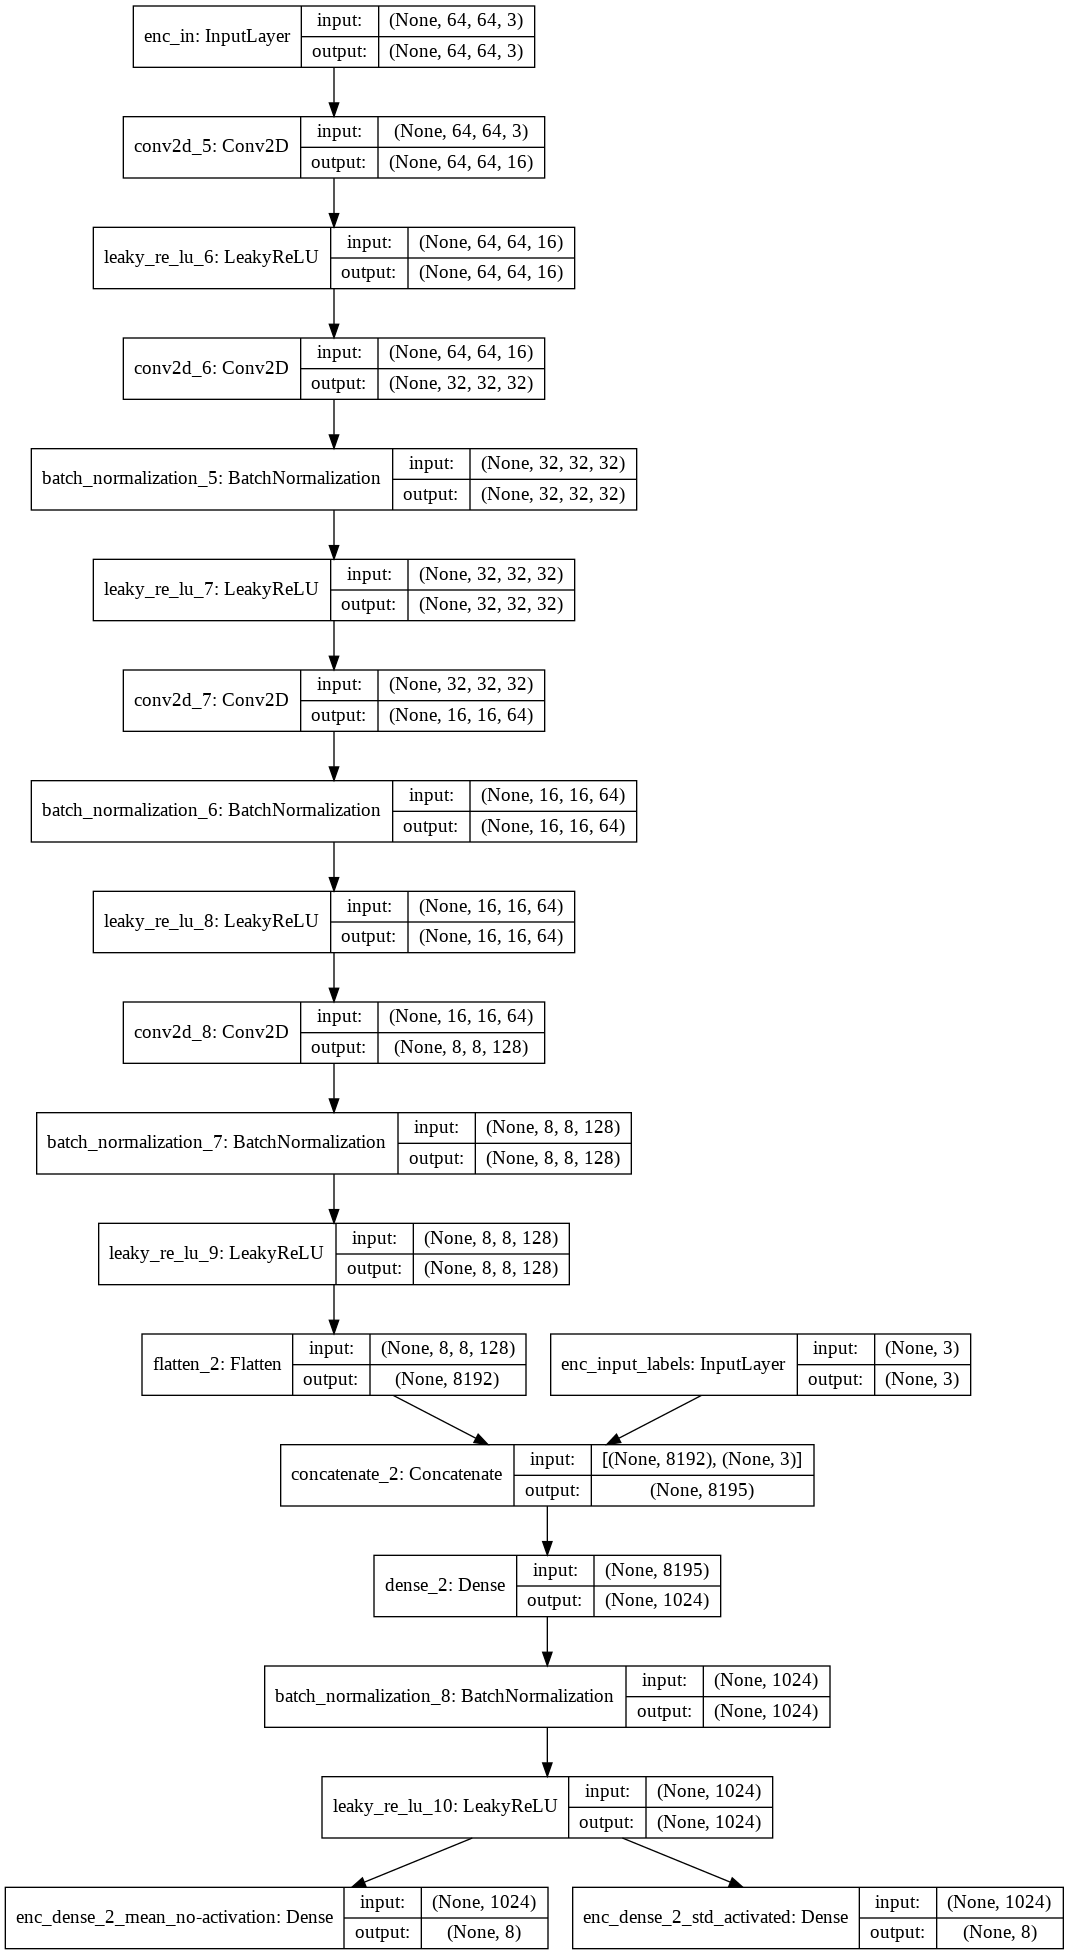

In [ ]:
# summary of the encoder
encoder.summary()
# plot model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='encoder.png')

In [ ]:
# VAE decoder 1
input_dec = Input(shape=(dec_dim,), name="dec_input")
#h_d = Dense(100, activation="relu", name="dec_dense_1_activated")(input_dec)
#h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(h_d)
#h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
#h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
#h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

##new
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)
#h_d = Reshape((dim_pre_flatten[0],dim_pre_flatten[1],dim_pre_flatten[2]//2),name="dec_reshape")(input_dec)
#h_d = Conv2DTranspose(filters= 64, kernel_size=4, strides=1, padding='valid', activation="relu", name="dec_trans-conv_1_activated")(h_d) # almost equivalent to FC (less bias terms)
h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)
h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)
##
h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)
h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)
decoder_1 = Model(inputs=input_dec, outputs = h_d, name="decoder")

In [ ]:
# VAE decoder 2 - inception units
input_dec = Input(shape=(dec_dim,), name="dec_input")
h_d = Dense(dim_post_flatten, name="dec_dense_2_no-activation")(input_dec)
h_d = BatchNormalization(name="dec_batchNorm_1")(h_d)
h_d = Activation(activation="relu", name="dec_relu_1")(h_d)
h_d = Reshape(dim_pre_flatten,name="dec_reshape")(h_d)

## inception 1
inc1_1 = Conv2D(filters= 16, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc1_2 = Conv2D(filters= 16, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc1_1,inc1_2])

h_d = Conv2DTranspose(filters= 32, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_2_activated")(h_d)

## inception 2
inc2_1 = Conv2D(filters= 8, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc2_2 = Conv2D(filters= 8, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc2_1,inc2_2])

h_d = Conv2DTranspose(filters= 16, kernel_size=3, strides=2, padding='same', activation="relu", name="dec_trans-conv_3_activated")(h_d)

## inception 3
inc3_1 = Conv2D(filters= 4, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc3_2 = Conv2D(filters= 4, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc3_1,inc3_2])

h_d = Conv2DTranspose(filters= 8, kernel_size=3, strides=2, padding='same', name="dec_trans-conv_4_no-activation")(h_d)
h_d = BatchNormalization(name="dec_batchNorm_2")(h_d)
h_d = Activation(activation="relu", name="dec_relu_2")(h_d)

## inception 4
inc4_1 = Conv2D(filters= 2, kernel_size=1, strides=1, padding='same', activation="relu")(h_d)
inc4_2 = Conv2D(filters= 2, kernel_size=3, strides=1, padding='same', activation="relu")(h_d)
h_d = concatenate([inc4_1,inc4_2])

h_d = Conv2DTranspose(filters= colors, kernel_size=3, strides=2, padding='same', activation="sigmoid", name="dec_trans-conv_5_activated")(h_d) # the activation depends on the data normalization (sigmoid or tanh)

decoder_2 = Model(inputs=input_dec, outputs = h_d, name="decoder")

In [ ]:
# decoder 3 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
# Dense 1
h = Dense(1024)(noise) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(7*7*128)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape((7, 7, 128))(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=5, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_3 = Model(noise,G_out,name="decoder")

In [ ]:
# decoder 4 - Generator
noise = Input(shape=(dec_dim,), name="G_in")
## add labels
input_dec_labels = Input(shape=(labels_dim,), name="dec_input_labels")
h = concatenate([noise,input_dec_labels])
# Dense 1
h = Dense(1024)(h) 
h = BatchNormalization(momentum=0.99)(h) #0.8
h = Activation("relu")(h)
# Dense 2
h = Dense(dim_post_flatten)(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Reshape
h = Reshape(dim_pre_flatten)(h)
# Conv 1
h = Conv2DTranspose(64, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 2
h = Conv2DTranspose(32, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv 3
h = Conv2DTranspose(16, kernel_size=filter_size, strides=2, padding="same")(h)
h = BatchNormalization(momentum=0.99)(h)
h = Activation("relu")(h)
# Conv to image
h = Conv2DTranspose(colors, kernel_size=1, strides=1, padding="same")(h)
G_out = Activation("sigmoid", name="G_out")(h)
decoder_4 = Model([noise,input_dec_labels],G_out,name="decoder")

In [ ]:
decoder = decoder_4

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
G_in (InputLayer)               (None, 8)            0                                            
__________________________________________________________________________________________________
dec_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 11)           0           G_in[0][0]                       
                                                                 dec_input_labels[0][0]           
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         12288       concatenate_3[0][0]        

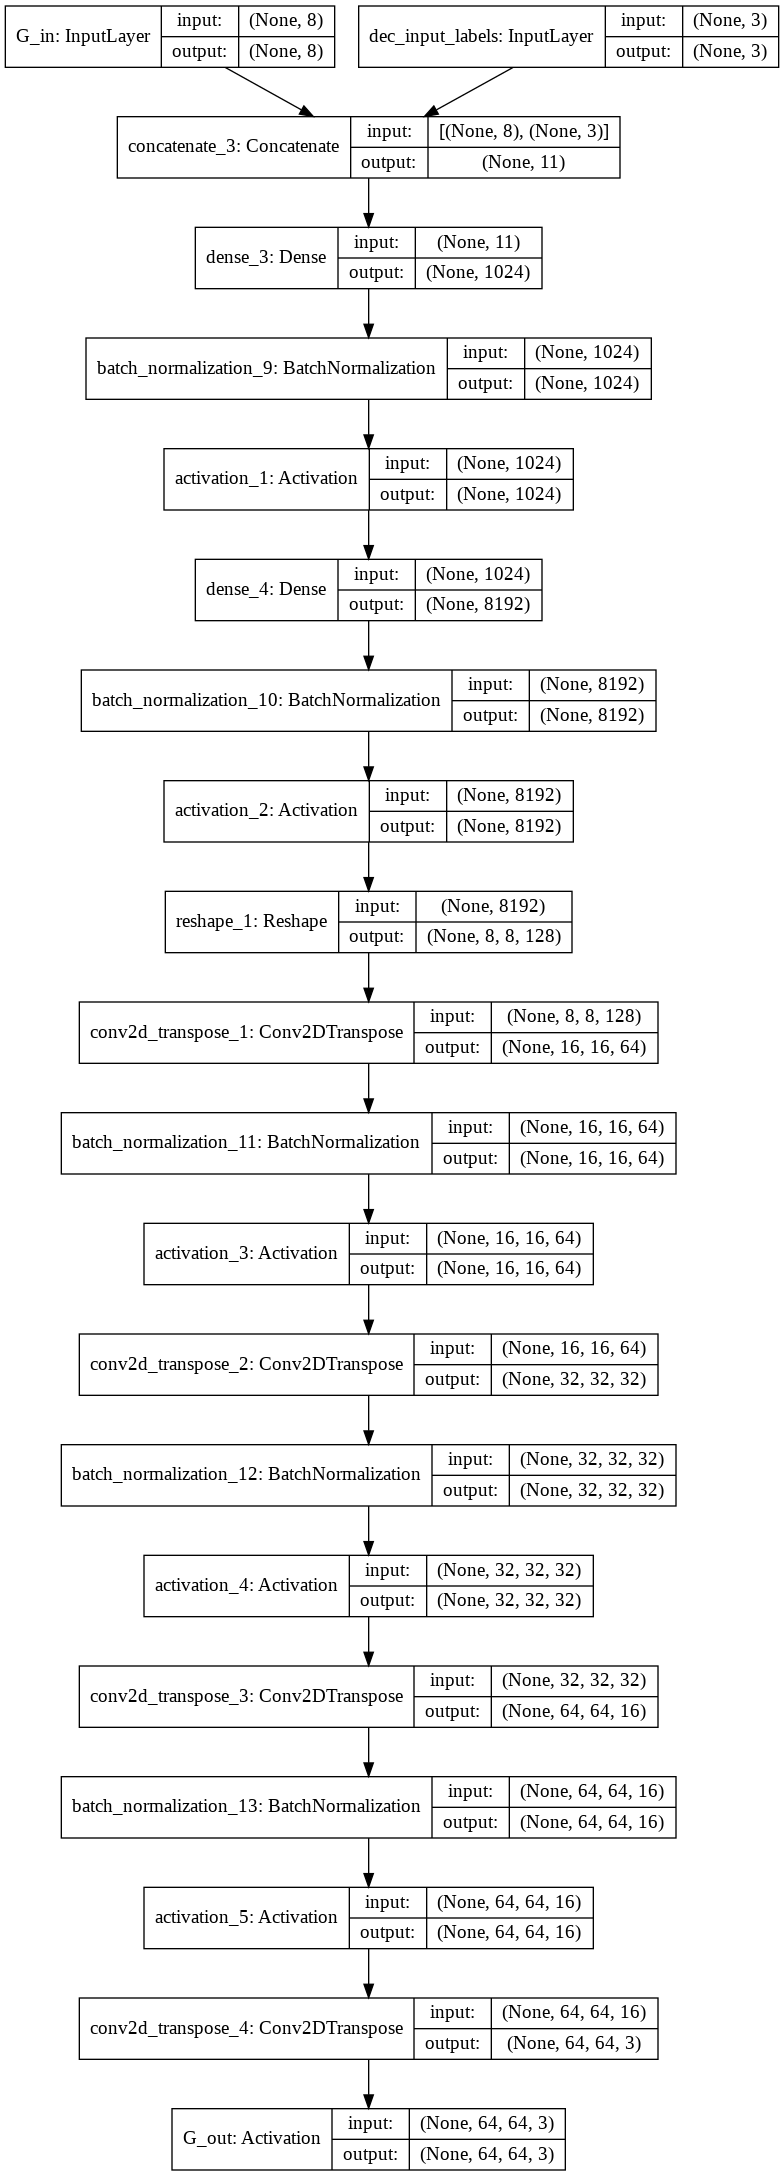

In [ ]:
# summary of the decoder
decoder.summary()
# plot model
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='decoder.png')

In [ ]:
# sampling function
def gaussian_sampling(tensors):
    mu, sigma = tensors
    #batch_shape = mu.shape # this way does not work to extract shape of tensor
    # two ways to exrtact tensor shape
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    return sigma*K.random_normal(shape=(batch, dim)) + mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

In [ ]:
# sampling function
def gaussian_sampling_array(arrays):
    mu, sigma = arrays
    batch = mu.shape[0]
    dim = mu.shape[1]
    return sigma* np.random.normal(size=(batch, dim))+ mu
    #batch_shape = K.shape(mu)
    #return sigma*K.random_normal(shape=batch_shape) + mu

In [ ]:

# VAE encoder + decoder
input_vae = Input(shape=(img_dim,img_dim,colors,), name="vae_input")
input_vae_labels = Input(shape=(labels_dim,), name="vae_input_labels")
z_latent = encoder([input_vae,input_vae_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian")
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_vae_labels])
else:
  output_vae = decoder([z_latent,input_vae_labels])
VAE = Model(inputs=[input_vae,input_vae_labels], outputs = output_vae)
#VAE = Model(inputs=input_vae, outputs = [output_vae,output_vae]) # two outputs to track two losses


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vae_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
vae_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     vae_input[0][0]                  
                                                                 vae_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[1][0]              

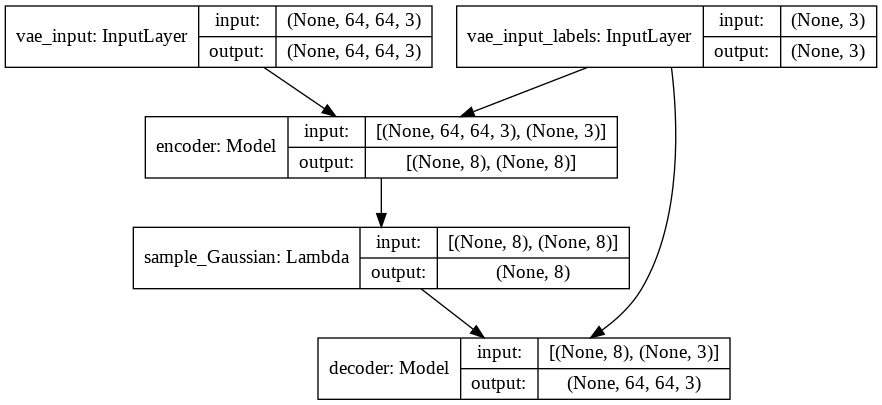

In [ ]:
# summary of the complete VAE
VAE.summary()
# plot model
plot_model(VAE, to_file='VAE.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='VAE.png')

In [ ]:
# Combined GAN: encoder + decoder + discriminator
input_GAN = Input(shape=(img_dim,img_dim,colors,), name="GAN_input")
input_GAN_labels = Input(shape=(labels_dim,), name="gan_input_labels")
z_latent = encoder([input_GAN,input_GAN_labels])
if ALPHA:
  sampling_layer = Lambda(gaussian_sampling,name="sample_Gaussian") 
  z_sample = sampling_layer(z_latent)
  output_vae = decoder([z_sample,input_GAN_labels])
else:
  output_vae = decoder([z_latent,input_GAN_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN = discriminator(output_vae)

# The combined model  (stacked generator and discriminator)
combined_GAN = Model([input_GAN,input_GAN_labels], output_GAN)

In [ ]:
'''
# GAN only: decoder(generator) + discriminator
input_gen = Input(shape=(dec_dim,), name="gen_input")
input_gen_labels = Input(shape=(labels_dim,), name="gen_input_labels")
output_gen = decoder([input_gen,input_gen_labels])
          
# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
output_GAN_disc = discriminator(output_gen)

# The combined model  (stacked generator and discriminator)
GAN = Model([input_gen,input_gen_labels], output_GAN_disc)
'''

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

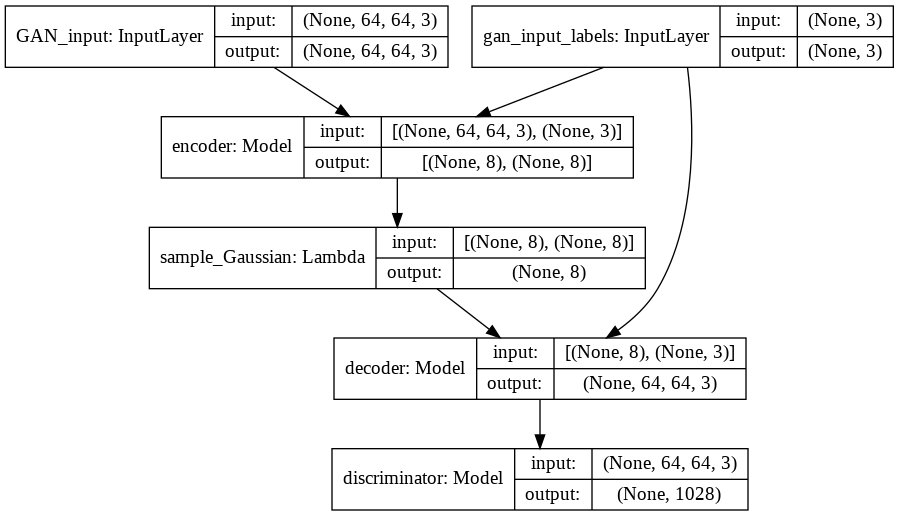

In [ ]:
# summary of the combined GAN
combined_GAN.summary()
# plot model
plot_model(combined_GAN, to_file='combined_GAN.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='combined_GAN.png')

In [ ]:
## K = keras.Backend
## z_latent = [noise, labels]

# VAE loss
def my_vae_loss(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= img_dim * img_dim

    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      vae_loss = K.mean(reconstruction_loss + BETA*kl_loss)
    else:
      vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_recon(y_true, y_pred):
    #reconstruction_loss = binary_crossentropy(K.flatten(y_true),K.flatten(y_pred))
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))

    reconstruction_loss *= img_dim * img_dim
    vae_loss = K.mean(reconstruction_loss)
    return vae_loss

def my_vae_loss_kl(y_true, y_pred):
    kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(kl_loss)
    return vae_loss

In [ ]:
# GAN loss with mse and labels and learned metric, one output
def my_GAN_loss(y_true, y_pred):
    ## true/false
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    ## labels
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    ## image reconstruction
    reconstruction_loss = img_dim * img_dim * mse(K.flatten(input_GAN), K.flatten(output_vae))
    ## features
    learned_metric = mse(y_true[:,1+labels_dim:],y_pred[:,1+labels_dim:])


    if ALPHA:
      #kl_loss = 1 + 2*K.log(z_std) - K.square(z_mu) - K.square(z_std) # this does NOT work (need to use the names as in the VAE)
      kl_loss = 1 + 2*K.log(z_latent[1]) - K.square(z_latent[0]) - K.square(z_latent[1])
      kl_loss = K.sum(kl_loss, axis=-1)
      kl_loss *= -0.5
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + BETA*kl_loss + DELTA*class_loss + GAMMA*learned_metric)
    else:
      GAN_loss = K.mean(adv_loss + ZETA*reconstruction_loss + DELTA*class_loss + GAMMA*learned_metric)
    return GAN_loss

In [ ]:
# discriminator loss with labels, one output
def my_disc_loss(y_true, y_pred):
    adv_loss = binary_crossentropy(y_true[:,0],y_pred[:,0])
    class_loss = categorical_crossentropy(y_true[:,1:1+labels_dim],y_pred[:,1:1+labels_dim])
    disc_loss = K.mean(adv_loss + DELTA*class_loss)
    return disc_loss

In [ ]:

#VAE.compile(Adam(lr=0.02), loss=my_vae_loss)
#VAE.compile(Adam(), loss=my_vae_loss)
VAE.compile(optimizer = optimizer, loss=my_vae_loss)

#VAE.compile(Adam(lr=0.02), loss = [my_vae_loss_recon,my_vae_loss_kl], loss_weights = [1,BETA]) # two losses


In [ ]:
combined_GAN.compile(optimizer = optimizer, loss=my_GAN_loss)

In [ ]:
'''
GAN.compile(optimizer = optimizer, loss='binary_crossentropy')
'''

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# compile discriminator with labels, one ouput
# second method, compile discriminator here after compiling combined GAN model and resetting trainable to true
discriminator.trainable = True
discriminator.compile(loss= my_disc_loss, optimizer= optimizer)

In [ ]:
'''
GAN.summary()
'''

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_input (InputLayer)       (None, 8)                 0         
_________________________________________________________________
decoder (Model)              (None, 64, 64, 3)         8712291   
_________________________________________________________________
discriminator (Model)        (None, 1)                 8664737   
Total params: 8,714,787
Trainable params: 8,693,635
Non-trainable params: 21,152
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
combined_GAN.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GAN_input (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
gan_input_labels (InputLayer)   (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 8), (None, 8 8511152     GAN_input[0][0]                  
                                                                 gan_input_labels[0][0]           
__________________________________________________________________________________________________
sample_Gaussian (Lambda)        (None, 8)            0           encoder[2][0]              

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
D_in (InputLayer)               (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
discriminator_metric (Model)    (None, 1024)         8491680     D_in[0][0]                       
__________________________________________________________________________________________________
D_out_adv (Dense)               (None, 1)            1025        discriminator_metric[1][0]       
__________________________________________________________________________________________________
D_out_labels (Dense)            (None, 3)            3075        discriminator_metric[1][0]       
______________________________________________________________________________________

In [ ]:
# Mount google drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
x_train = np.load('/content/drive/My Drive/Colab/GAN/Pytorch/galaxyzoo_data_cropped_nonnormalized.npy')
x_train = x_train/255.0

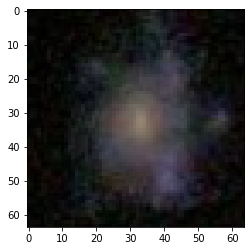

In [ ]:
plt.imshow(x_train[8])

In [ ]:
import pandas as pd
df =  pd.read_csv('/content/drive/My Drive/Colab/GAN/Pytorch/training_solutions_rev1.csv')
labels_train = np.array(df[df.columns[1:4]])

In [ ]:
labels_train.shape

(61578, 3)

In [ ]:
epochs=20
batch_size=128
save_interval=200
      
d_costs = []
g_costs = []

N = len(x_train)
n_batches = N // batch_size
total_iter = 0

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# make dir to save My_samples
if not os.path.exists('/content/drive/My Drive/Colab/VAE/images_GAN'):
  os.mkdir('/content/drive/My Drive/Colab/VAE/images_GAN')

In [ ]:
def save_imgs(iteration,gen_imgs):
        r, c = 8, 8
        #noise = np.random.normal(0, 1, (r * c, latent_dim))
        #gen_imgs = decoder.predict(noise)
        
        
        d = img_dim
        
        if gen_imgs.shape[-1] == 1:
            # if color == 1, we want a 2-D image (N x N)
            gen_imgs = gen_imgs.reshape(r*c, d, d)
            flat_image = np.empty((r*d, c*d))

            k = 0
            for i in range(8):
              for j in range(8):
                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k].reshape(d, d)
                k += 1

            
        else:
          # if color == 3, we want a 3-D image (N x N x 3)
          flat_image = np.empty((r*d, c*d, 3))
          k = 0
          for i in range(8):
            for j in range(8):
              flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = gen_imgs[k]
              #flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = (gen_imgs[k]+1)/2 # MD (not necessary, the png or jpg preview visualize both ranges the same way)
              k += 1
            
            
        # plt.savefig('samples/samples_at_iter_%d.png' % total_iters)
        #sp.misc.imsave('/content/drive/My Drive/Colab/VAE/images/samples_at_iter_%d.png' % iteration,flat_image)
        imageio.imwrite('/content/drive/My Drive/Colab/VAE/images_GAN/samples_at_iter_%d.png' % iteration,flat_image)

In [ ]:
# train GAN or combined GAN
for epoch in range(epochs):
        
      print("epoch:", epoch+1)
      #np.random.shuffle(x_train)
      idx = np.random.permutation(len(x_train))
      x_train = x_train[idx]
      labels_train = labels_train[idx]
        
      for j in range(n_batches):
        t0 = datetime.now()
      
      

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a batch of images
        imgs = x_train[j*batch_size:(j+1)*batch_size]

        labels = labels_train[j*batch_size:(j+1)*batch_size]
      
        # Sample noise and generate a batch of new images
        #noise = np.random.normal(0, 1, (batch_size, latent_dim))
        #gen_imgs = decoder.predict(noise)

        #noise_latent = encoder.predict(imgs)
        #if ALPHA:
          #gen_imgs = decoder.predict(gaussian_sampling_array(noise_latent))
        #else:
          #gen_imgs = decoder.predict(noise_latent)

        gen_imgs = VAE.predict([imgs,labels])
          

        # Train the discriminator (real classified as ones and generated as zeros)
        #d_loss_real = discriminator.train_on_batch(imgs, [valid,labels])
        #d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake,labels])
        d_loss_real = discriminator.train_on_batch(imgs, np.concatenate((valid,labels),axis=1))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.concatenate((fake,labels),axis=1))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        #d_loss = np.add(d_loss_real, d_loss_fake)
          
        d_costs.append(d_loss)
          

        # ---------------------
        #  Train Generator
        # ---------------------

        metric_real = discriminator_metric.predict(imgs)

        # Train the generator (wants discriminator to mistake images as real)
        #g_loss = combined_GAN.train_on_batch([imgs,labels], [valid,labels])
        g_loss = combined_GAN.train_on_batch([imgs,labels], np.concatenate((valid,labels,metric_real),axis=1))


        #g_loss = GAN.train_on_batch(noise, valid)
          
        g_costs.append(g_loss)

        # Plot the progress
        #print ("Epoch %d - Batch: %d/%d [D loss: %f, acc.: %.2f%%] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss[0], 100*d_loss[1], g_loss[0],datetime.now() - t0))
        print ("Epoch %d - Batch: %d/%d [D loss: %f] [G loss: %f] dt: %s " % (epoch+1,j+1,n_batches, d_loss, g_loss,datetime.now() - t0))
        total_iter += 1        
        # If at save interval => save generated image samples
        if total_iter  % save_interval == 0:
          save_imgs(total_iter,gen_imgs[:64])

# save a plot of the costs
plt.clf()
plt.plot(d_costs, label='discriminator cost')
plt.plot(g_costs, label='generator cost')
plt.legend()
plt.savefig('/content/drive/My Drive/Colab/VAE/images_GAN/cost_vs_iteration.png')
plt.close()

# save models
#combined_GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/combined_GAN_model')
#VAE.save('/content/drive/My Drive/Colab/VAE/images_GAN/VAE_model')
#GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/GAN_model')

epoch: 1

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 - Batch: 1/481 [D loss: 2.178514] [G loss: 789.477600] dt: 0:00:15.541109 
Epoch 1 - Batch: 2/481 [D loss: 3.493188] [G loss: 784.355835] dt: 0:00:00.144221 


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 - Batch: 3/481 [D loss: 2.273652] [G loss: 772.610840] dt: 0:00:00.133362 
Epoch 1 - Batch: 4/481 [D loss: 1.871410] [G loss: 753.325073] dt: 0:00:00.135061 
Epoch 1 - Batch: 5/481 [D loss: 1.670251] [G loss: 738.827332] dt: 0:00:00.138537 
Epoch 1 - Batch: 6/481 [D loss: 1.772981] [G loss: 723.182007] dt: 0:00:00.134738 
Epoch 1 - Batch: 7/481 [D loss: 1.880867] [G loss: 691.206055] dt: 0:00:00.137839 
Epoch 1 - Batch: 8/481 [D loss: 1.555780] [G loss: 669.726624] dt: 0:00:00.132438 
Epoch 1 - Batch: 9/481 [D loss: 1.510227] [G loss: 649.110474] dt: 0:00:00.136082 
Epoch 1 - Batch: 10/481 [D loss: 1.363926] [G loss: 617.163208] dt: 0:00:00.138183 
Epoch 1 - Batch: 11/481 [D loss: 1.265537] [G loss: 607.846680] dt: 0:00:00.137185 
Epoch 1 - Batch: 12/481 [D loss: 1.216077] [G loss: 586.742859] dt: 0:00:00.140949 
Epoch 1 - Batch: 13/481 [D loss: 1.241325] [G loss: 569.336609] dt: 0:00:00.143560 
Epoch 1 - Batch: 14/481 [D loss: 1.245874] [G loss: 548.837219] dt: 0:00:00.139910 

Epoch 1 - Batch: 199/481 [D loss: 0.789690] [G loss: 761.026733] dt: 0:00:00.133037 
Epoch 1 - Batch: 200/481 [D loss: 0.789919] [G loss: 704.692261] dt: 0:00:00.136036 
Epoch 1 - Batch: 201/481 [D loss: 0.834952] [G loss: 715.072266] dt: 0:00:00.131577 
Epoch 1 - Batch: 202/481 [D loss: 0.966456] [G loss: 772.210266] dt: 0:00:00.133060 
Epoch 1 - Batch: 203/481 [D loss: 0.791027] [G loss: 762.870850] dt: 0:00:00.135620 
Epoch 1 - Batch: 204/481 [D loss: 0.746363] [G loss: 727.722778] dt: 0:00:00.131542 
Epoch 1 - Batch: 205/481 [D loss: 0.735241] [G loss: 748.678894] dt: 0:00:00.134341 
Epoch 1 - Batch: 206/481 [D loss: 0.670496] [G loss: 715.875488] dt: 0:00:00.136015 
Epoch 1 - Batch: 207/481 [D loss: 0.752880] [G loss: 748.520325] dt: 0:00:00.130417 
Epoch 1 - Batch: 208/481 [D loss: 0.706195] [G loss: 688.895020] dt: 0:00:00.130163 
Epoch 1 - Batch: 209/481 [D loss: 0.773126] [G loss: 776.933472] dt: 0:00:00.132278 
Epoch 1 - Batch: 210/481 [D loss: 0.872692] [G loss: 666.278320] 

Epoch 1 - Batch: 399/481 [D loss: 0.720520] [G loss: 577.716980] dt: 0:00:00.131041 
Epoch 1 - Batch: 400/481 [D loss: 0.721484] [G loss: 397.399292] dt: 0:00:00.133059 
Epoch 1 - Batch: 401/481 [D loss: 0.749807] [G loss: 368.294861] dt: 0:00:00.132638 
Epoch 1 - Batch: 402/481 [D loss: 0.978536] [G loss: 457.397125] dt: 0:00:00.134870 
Epoch 1 - Batch: 403/481 [D loss: 0.998977] [G loss: 815.381226] dt: 0:00:00.136909 
Epoch 1 - Batch: 404/481 [D loss: 1.403868] [G loss: 769.355225] dt: 0:00:00.137217 
Epoch 1 - Batch: 405/481 [D loss: 2.200923] [G loss: 1049.094849] dt: 0:00:00.132599 
Epoch 1 - Batch: 406/481 [D loss: 2.118985] [G loss: 2906.582520] dt: 0:00:00.128768 
Epoch 1 - Batch: 407/481 [D loss: 1.491050] [G loss: 1438.303345] dt: 0:00:00.131610 
Epoch 1 - Batch: 408/481 [D loss: 1.535751] [G loss: 1211.579102] dt: 0:00:00.133535 
Epoch 1 - Batch: 409/481 [D loss: 1.030550] [G loss: 1117.875854] dt: 0:00:00.136091 
Epoch 1 - Batch: 410/481 [D loss: 0.993620] [G loss: 1039.77

Epoch 2 - Batch: 119/481 [D loss: 1.422282] [G loss: 970.565308] dt: 0:00:00.131699 
Epoch 2 - Batch: 120/481 [D loss: 1.000413] [G loss: 919.365295] dt: 0:00:00.130903 
Epoch 2 - Batch: 121/481 [D loss: 0.964870] [G loss: 1095.059448] dt: 0:00:00.133515 
Epoch 2 - Batch: 122/481 [D loss: 0.900829] [G loss: 1280.642334] dt: 0:00:00.135164 
Epoch 2 - Batch: 123/481 [D loss: 0.946909] [G loss: 1128.964844] dt: 0:00:00.133865 
Epoch 2 - Batch: 124/481 [D loss: 1.062383] [G loss: 1122.018311] dt: 0:00:00.134480 
Epoch 2 - Batch: 125/481 [D loss: 1.002864] [G loss: 1314.040039] dt: 0:00:00.132947 
Epoch 2 - Batch: 126/481 [D loss: 1.145924] [G loss: 966.692993] dt: 0:00:00.134815 
Epoch 2 - Batch: 127/481 [D loss: 1.131665] [G loss: 1050.665161] dt: 0:00:00.130131 
Epoch 2 - Batch: 128/481 [D loss: 0.962371] [G loss: 1104.370605] dt: 0:00:00.133210 
Epoch 2 - Batch: 129/481 [D loss: 0.909594] [G loss: 1032.736084] dt: 0:00:00.132744 
Epoch 2 - Batch: 130/481 [D loss: 0.952804] [G loss: 955.

Epoch 2 - Batch: 318/481 [D loss: 0.990205] [G loss: 610.266785] dt: 0:00:00.130077 
Epoch 2 - Batch: 319/481 [D loss: 0.917386] [G loss: 610.034973] dt: 0:00:00.128535 
Epoch 2 - Batch: 320/481 [D loss: 0.830344] [G loss: 530.625305] dt: 0:00:00.134021 
Epoch 2 - Batch: 321/481 [D loss: 0.897988] [G loss: 547.960144] dt: 0:00:00.130946 
Epoch 2 - Batch: 322/481 [D loss: 0.948913] [G loss: 563.960815] dt: 0:00:00.134207 
Epoch 2 - Batch: 323/481 [D loss: 0.897773] [G loss: 588.076904] dt: 0:00:00.131214 
Epoch 2 - Batch: 324/481 [D loss: 1.046156] [G loss: 512.841675] dt: 0:00:00.132383 
Epoch 2 - Batch: 325/481 [D loss: 0.992568] [G loss: 570.864136] dt: 0:00:00.131927 
Epoch 2 - Batch: 326/481 [D loss: 1.054048] [G loss: 672.442139] dt: 0:00:00.130790 
Epoch 2 - Batch: 327/481 [D loss: 1.159740] [G loss: 720.747009] dt: 0:00:00.131677 
Epoch 2 - Batch: 328/481 [D loss: 1.134363] [G loss: 632.630493] dt: 0:00:00.137146 
Epoch 2 - Batch: 329/481 [D loss: 0.881781] [G loss: 714.361694] 

Epoch 3 - Batch: 37/481 [D loss: 0.902617] [G loss: 371.696594] dt: 0:00:00.135706 
Epoch 3 - Batch: 38/481 [D loss: 0.970650] [G loss: 327.992859] dt: 0:00:00.129706 
Epoch 3 - Batch: 39/481 [D loss: 1.102563] [G loss: 304.998291] dt: 0:00:00.131067 
Epoch 3 - Batch: 40/481 [D loss: 0.968738] [G loss: 350.970032] dt: 0:00:00.128576 
Epoch 3 - Batch: 41/481 [D loss: 0.917671] [G loss: 474.051392] dt: 0:00:00.133875 
Epoch 3 - Batch: 42/481 [D loss: 1.119118] [G loss: 625.837158] dt: 0:00:00.134646 
Epoch 3 - Batch: 43/481 [D loss: 1.064937] [G loss: 384.738647] dt: 0:00:00.138307 
Epoch 3 - Batch: 44/481 [D loss: 0.867469] [G loss: 288.798157] dt: 0:00:00.132921 
Epoch 3 - Batch: 45/481 [D loss: 1.080637] [G loss: 310.136658] dt: 0:00:00.131372 
Epoch 3 - Batch: 46/481 [D loss: 0.884491] [G loss: 262.042969] dt: 0:00:00.132994 
Epoch 3 - Batch: 47/481 [D loss: 0.869924] [G loss: 328.651733] dt: 0:00:00.135307 
Epoch 3 - Batch: 48/481 [D loss: 0.788396] [G loss: 324.234131] dt: 0:00:00.

Epoch 3 - Batch: 237/481 [D loss: 1.027814] [G loss: 305.615967] dt: 0:00:00.129326 
Epoch 3 - Batch: 238/481 [D loss: 0.902682] [G loss: 539.266968] dt: 0:00:00.128409 
Epoch 3 - Batch: 239/481 [D loss: 0.923227] [G loss: 540.058228] dt: 0:00:00.135737 
Epoch 3 - Batch: 240/481 [D loss: 1.014761] [G loss: 511.599487] dt: 0:00:00.134959 
Epoch 3 - Batch: 241/481 [D loss: 1.050926] [G loss: 520.456787] dt: 0:00:00.134749 
Epoch 3 - Batch: 242/481 [D loss: 1.501913] [G loss: 616.146851] dt: 0:00:00.128197 
Epoch 3 - Batch: 243/481 [D loss: 1.126488] [G loss: 654.618408] dt: 0:00:00.134685 
Epoch 3 - Batch: 244/481 [D loss: 0.994079] [G loss: 957.935913] dt: 0:00:00.129183 
Epoch 3 - Batch: 245/481 [D loss: 0.824670] [G loss: 750.940247] dt: 0:00:00.132572 
Epoch 3 - Batch: 246/481 [D loss: 0.847450] [G loss: 507.684448] dt: 0:00:00.127861 
Epoch 3 - Batch: 247/481 [D loss: 0.858373] [G loss: 480.505585] dt: 0:00:00.132563 
Epoch 3 - Batch: 248/481 [D loss: 0.806708] [G loss: 410.474487] 

Epoch 3 - Batch: 437/481 [D loss: 0.939440] [G loss: 314.855865] dt: 0:00:00.133862 
Epoch 3 - Batch: 438/481 [D loss: 0.798730] [G loss: 238.688171] dt: 0:00:00.131282 
Epoch 3 - Batch: 439/481 [D loss: 0.786961] [G loss: 243.035629] dt: 0:00:00.134856 
Epoch 3 - Batch: 440/481 [D loss: 0.776011] [G loss: 208.188736] dt: 0:00:00.139188 
Epoch 3 - Batch: 441/481 [D loss: 0.793561] [G loss: 232.220886] dt: 0:00:00.136484 
Epoch 3 - Batch: 442/481 [D loss: 0.733201] [G loss: 199.846313] dt: 0:00:00.132991 
Epoch 3 - Batch: 443/481 [D loss: 0.807129] [G loss: 281.363983] dt: 0:00:00.132237 
Epoch 3 - Batch: 444/481 [D loss: 0.985752] [G loss: 316.477814] dt: 0:00:00.130970 
Epoch 3 - Batch: 445/481 [D loss: 0.820418] [G loss: 264.000122] dt: 0:00:00.135007 
Epoch 3 - Batch: 446/481 [D loss: 0.828633] [G loss: 455.858032] dt: 0:00:00.130970 
Epoch 3 - Batch: 447/481 [D loss: 0.781214] [G loss: 292.405273] dt: 0:00:00.132250 
Epoch 3 - Batch: 448/481 [D loss: 0.727504] [G loss: 209.829865] 

Epoch 4 - Batch: 157/481 [D loss: 1.287832] [G loss: 1573.643311] dt: 0:00:00.134408 
Epoch 4 - Batch: 158/481 [D loss: 1.051890] [G loss: 1607.197021] dt: 0:00:00.134852 
Epoch 4 - Batch: 159/481 [D loss: 1.036531] [G loss: 550.096191] dt: 0:00:00.133714 
Epoch 4 - Batch: 160/481 [D loss: 0.957826] [G loss: 351.283752] dt: 0:00:00.138149 
Epoch 4 - Batch: 161/481 [D loss: 0.921193] [G loss: 348.464539] dt: 0:00:00.134205 
Epoch 4 - Batch: 162/481 [D loss: 1.022269] [G loss: 327.933533] dt: 0:00:00.134632 
Epoch 4 - Batch: 163/481 [D loss: 0.887420] [G loss: 296.168518] dt: 0:00:00.132938 
Epoch 4 - Batch: 164/481 [D loss: 0.879029] [G loss: 354.472321] dt: 0:00:00.131989 
Epoch 4 - Batch: 165/481 [D loss: 0.855585] [G loss: 231.857010] dt: 0:00:00.129892 
Epoch 4 - Batch: 166/481 [D loss: 0.815185] [G loss: 227.928558] dt: 0:00:00.135961 
Epoch 4 - Batch: 167/481 [D loss: 0.817298] [G loss: 285.534424] dt: 0:00:00.132776 
Epoch 4 - Batch: 168/481 [D loss: 0.745001] [G loss: 239.187683

Epoch 4 - Batch: 356/481 [D loss: 1.178097] [G loss: 1053.979004] dt: 0:00:00.132080 
Epoch 4 - Batch: 357/481 [D loss: 1.159807] [G loss: 744.326172] dt: 0:00:00.129815 
Epoch 4 - Batch: 358/481 [D loss: 0.969175] [G loss: 434.343658] dt: 0:00:00.132514 
Epoch 4 - Batch: 359/481 [D loss: 0.974582] [G loss: 723.702148] dt: 0:00:00.133088 
Epoch 4 - Batch: 360/481 [D loss: 0.913216] [G loss: 330.313751] dt: 0:00:00.137090 
Epoch 4 - Batch: 361/481 [D loss: 0.925011] [G loss: 739.525208] dt: 0:00:00.135616 
Epoch 4 - Batch: 362/481 [D loss: 0.957466] [G loss: 314.761902] dt: 0:00:00.130430 
Epoch 4 - Batch: 363/481 [D loss: 1.201403] [G loss: 354.907715] dt: 0:00:00.128044 
Epoch 4 - Batch: 364/481 [D loss: 1.497232] [G loss: 391.032166] dt: 0:00:00.133121 
Epoch 4 - Batch: 365/481 [D loss: 1.020279] [G loss: 406.631226] dt: 0:00:00.130793 
Epoch 4 - Batch: 366/481 [D loss: 1.201103] [G loss: 714.610840] dt: 0:00:00.133185 
Epoch 4 - Batch: 367/481 [D loss: 0.878875] [G loss: 242.105072]

Epoch 5 - Batch: 75/481 [D loss: 0.847020] [G loss: 478.988464] dt: 0:00:00.130637 
Epoch 5 - Batch: 76/481 [D loss: 0.973667] [G loss: 307.576233] dt: 0:00:00.131837 
Epoch 5 - Batch: 77/481 [D loss: 0.992557] [G loss: 230.261520] dt: 0:00:00.137189 
Epoch 5 - Batch: 78/481 [D loss: 1.122095] [G loss: 434.660278] dt: 0:00:00.132399 
Epoch 5 - Batch: 79/481 [D loss: 0.939097] [G loss: 339.750671] dt: 0:00:00.131841 
Epoch 5 - Batch: 80/481 [D loss: 0.898442] [G loss: 322.648438] dt: 0:00:00.130670 
Epoch 5 - Batch: 81/481 [D loss: 0.801513] [G loss: 392.173401] dt: 0:00:00.132361 
Epoch 5 - Batch: 82/481 [D loss: 0.839589] [G loss: 455.989258] dt: 0:00:00.132192 
Epoch 5 - Batch: 83/481 [D loss: 0.859345] [G loss: 293.383148] dt: 0:00:00.131895 
Epoch 5 - Batch: 84/481 [D loss: 0.875644] [G loss: 245.455612] dt: 0:00:00.133976 
Epoch 5 - Batch: 85/481 [D loss: 0.800898] [G loss: 250.507156] dt: 0:00:00.131660 
Epoch 5 - Batch: 86/481 [D loss: 0.836081] [G loss: 376.395081] dt: 0:00:00.

Epoch 5 - Batch: 275/481 [D loss: 0.864233] [G loss: 371.859924] dt: 0:00:00.132507 
Epoch 5 - Batch: 276/481 [D loss: 0.823464] [G loss: 257.306030] dt: 0:00:00.137848 
Epoch 5 - Batch: 277/481 [D loss: 0.742644] [G loss: 278.488892] dt: 0:00:00.139576 
Epoch 5 - Batch: 278/481 [D loss: 0.767359] [G loss: 259.225281] dt: 0:00:00.135883 
Epoch 5 - Batch: 279/481 [D loss: 0.751918] [G loss: 286.571564] dt: 0:00:00.138130 
Epoch 5 - Batch: 280/481 [D loss: 0.822172] [G loss: 352.017578] dt: 0:00:00.129298 
Epoch 5 - Batch: 281/481 [D loss: 0.831507] [G loss: 327.301331] dt: 0:00:00.133887 
Epoch 5 - Batch: 282/481 [D loss: 0.783273] [G loss: 253.091965] dt: 0:00:00.128903 
Epoch 5 - Batch: 283/481 [D loss: 0.822621] [G loss: 190.538086] dt: 0:00:00.130717 
Epoch 5 - Batch: 284/481 [D loss: 0.790217] [G loss: 250.036804] dt: 0:00:00.129486 
Epoch 5 - Batch: 285/481 [D loss: 0.732393] [G loss: 335.177917] dt: 0:00:00.135820 
Epoch 5 - Batch: 286/481 [D loss: 0.772291] [G loss: 270.580688] 

Epoch 5 - Batch: 475/481 [D loss: 0.733936] [G loss: 205.739807] dt: 0:00:00.132389 
Epoch 5 - Batch: 476/481 [D loss: 0.795838] [G loss: 194.405869] dt: 0:00:00.128671 
Epoch 5 - Batch: 477/481 [D loss: 0.863554] [G loss: 273.457458] dt: 0:00:00.132794 
Epoch 5 - Batch: 478/481 [D loss: 0.844865] [G loss: 305.851685] dt: 0:00:00.133263 
Epoch 5 - Batch: 479/481 [D loss: 0.795743] [G loss: 496.388641] dt: 0:00:00.132237 
Epoch 5 - Batch: 480/481 [D loss: 0.838472] [G loss: 420.590210] dt: 0:00:00.130538 
Epoch 5 - Batch: 481/481 [D loss: 0.875748] [G loss: 254.947067] dt: 0:00:00.133786 
epoch: 6
Epoch 6 - Batch: 1/481 [D loss: 0.819004] [G loss: 476.812195] dt: 0:00:00.138032 
Epoch 6 - Batch: 2/481 [D loss: 1.499497] [G loss: 1271.103516] dt: 0:00:00.134356 
Epoch 6 - Batch: 3/481 [D loss: 2.323484] [G loss: 1561.342041] dt: 0:00:00.134561 
Epoch 6 - Batch: 4/481 [D loss: 1.549905] [G loss: 1505.176880] dt: 0:00:00.133692 
Epoch 6 - Batch: 5/481 [D loss: 1.086953] [G loss: 1053.32678

Epoch 6 - Batch: 195/481 [D loss: 0.757960] [G loss: 214.072937] dt: 0:00:00.130295 
Epoch 6 - Batch: 196/481 [D loss: 0.715111] [G loss: 258.606812] dt: 0:00:00.130847 
Epoch 6 - Batch: 197/481 [D loss: 0.774001] [G loss: 625.199219] dt: 0:00:00.129103 
Epoch 6 - Batch: 198/481 [D loss: 0.729168] [G loss: 292.753143] dt: 0:00:00.129558 
Epoch 6 - Batch: 199/481 [D loss: 0.722889] [G loss: 217.799652] dt: 0:00:00.131521 
Epoch 6 - Batch: 200/481 [D loss: 0.742832] [G loss: 223.541245] dt: 0:00:00.132043 
Epoch 6 - Batch: 201/481 [D loss: 0.755745] [G loss: 235.504211] dt: 0:00:00.135902 
Epoch 6 - Batch: 202/481 [D loss: 0.789686] [G loss: 245.169891] dt: 0:00:00.141719 
Epoch 6 - Batch: 203/481 [D loss: 0.697352] [G loss: 235.959274] dt: 0:00:00.132767 
Epoch 6 - Batch: 204/481 [D loss: 0.698762] [G loss: 202.714081] dt: 0:00:00.136265 
Epoch 6 - Batch: 205/481 [D loss: 0.674171] [G loss: 239.592987] dt: 0:00:00.132638 
Epoch 6 - Batch: 206/481 [D loss: 0.718489] [G loss: 252.320496] 

Epoch 6 - Batch: 394/481 [D loss: 0.797598] [G loss: 201.248016] dt: 0:00:00.135501 
Epoch 6 - Batch: 395/481 [D loss: 0.810862] [G loss: 178.080811] dt: 0:00:00.130807 
Epoch 6 - Batch: 396/481 [D loss: 0.718268] [G loss: 225.130859] dt: 0:00:00.137060 
Epoch 6 - Batch: 397/481 [D loss: 0.768658] [G loss: 191.483261] dt: 0:00:00.136644 
Epoch 6 - Batch: 398/481 [D loss: 0.706062] [G loss: 402.335632] dt: 0:00:00.139127 
Epoch 6 - Batch: 399/481 [D loss: 0.774789] [G loss: 262.609558] dt: 0:00:00.138133 
Epoch 6 - Batch: 400/481 [D loss: 0.721624] [G loss: 180.817429] dt: 0:00:00.135064 
Epoch 6 - Batch: 401/481 [D loss: 0.724550] [G loss: 155.614410] dt: 0:00:00.128571 
Epoch 6 - Batch: 402/481 [D loss: 0.794337] [G loss: 180.760071] dt: 0:00:00.131201 
Epoch 6 - Batch: 403/481 [D loss: 0.752662] [G loss: 204.863861] dt: 0:00:00.131531 
Epoch 6 - Batch: 404/481 [D loss: 0.730269] [G loss: 334.269135] dt: 0:00:00.133745 
Epoch 6 - Batch: 405/481 [D loss: 0.773904] [G loss: 222.684601] 

Epoch 7 - Batch: 113/481 [D loss: 0.805684] [G loss: 285.067749] dt: 0:00:00.131738 
Epoch 7 - Batch: 114/481 [D loss: 0.922603] [G loss: 294.415833] dt: 0:00:00.131625 
Epoch 7 - Batch: 115/481 [D loss: 1.079196] [G loss: 194.878860] dt: 0:00:00.134174 
Epoch 7 - Batch: 116/481 [D loss: 0.964501] [G loss: 194.872375] dt: 0:00:00.132151 
Epoch 7 - Batch: 117/481 [D loss: 0.876647] [G loss: 215.115784] dt: 0:00:00.133189 
Epoch 7 - Batch: 118/481 [D loss: 0.796786] [G loss: 331.276550] dt: 0:00:00.129307 
Epoch 7 - Batch: 119/481 [D loss: 0.761216] [G loss: 299.438995] dt: 0:00:00.131418 
Epoch 7 - Batch: 120/481 [D loss: 0.738341] [G loss: 304.836395] dt: 0:00:00.134920 
Epoch 7 - Batch: 121/481 [D loss: 0.839994] [G loss: 351.871826] dt: 0:00:00.136654 
Epoch 7 - Batch: 122/481 [D loss: 0.766405] [G loss: 204.605316] dt: 0:00:00.135777 
Epoch 7 - Batch: 123/481 [D loss: 0.748110] [G loss: 247.622345] dt: 0:00:00.134025 
Epoch 7 - Batch: 124/481 [D loss: 0.742530] [G loss: 299.797852] 

Epoch 7 - Batch: 313/481 [D loss: 0.731002] [G loss: 163.646301] dt: 0:00:00.132972 
Epoch 7 - Batch: 314/481 [D loss: 0.687703] [G loss: 170.587158] dt: 0:00:00.134051 
Epoch 7 - Batch: 315/481 [D loss: 0.740894] [G loss: 270.406555] dt: 0:00:00.131902 
Epoch 7 - Batch: 316/481 [D loss: 0.716764] [G loss: 203.155319] dt: 0:00:00.130145 
Epoch 7 - Batch: 317/481 [D loss: 0.782453] [G loss: 181.429306] dt: 0:00:00.129664 
Epoch 7 - Batch: 318/481 [D loss: 0.678262] [G loss: 185.768280] dt: 0:00:00.134319 
Epoch 7 - Batch: 319/481 [D loss: 0.719624] [G loss: 217.491028] dt: 0:00:00.133616 
Epoch 7 - Batch: 320/481 [D loss: 0.752130] [G loss: 233.665222] dt: 0:00:00.135508 
Epoch 7 - Batch: 321/481 [D loss: 0.742142] [G loss: 270.068207] dt: 0:00:00.133868 
Epoch 7 - Batch: 322/481 [D loss: 0.716204] [G loss: 220.149811] dt: 0:00:00.131033 
Epoch 7 - Batch: 323/481 [D loss: 0.696419] [G loss: 294.872559] dt: 0:00:00.128607 
Epoch 7 - Batch: 324/481 [D loss: 0.737683] [G loss: 238.572815] 

Epoch 8 - Batch: 33/481 [D loss: 0.722291] [G loss: 195.819962] dt: 0:00:00.130796 
Epoch 8 - Batch: 34/481 [D loss: 0.771535] [G loss: 323.118408] dt: 0:00:00.130073 
Epoch 8 - Batch: 35/481 [D loss: 0.782456] [G loss: 230.852203] dt: 0:00:00.131613 
Epoch 8 - Batch: 36/481 [D loss: 0.779784] [G loss: 338.852570] dt: 0:00:00.130710 
Epoch 8 - Batch: 37/481 [D loss: 0.742304] [G loss: 292.251343] dt: 0:00:00.127813 
Epoch 8 - Batch: 38/481 [D loss: 0.730201] [G loss: 224.503540] dt: 0:00:00.131199 
Epoch 8 - Batch: 39/481 [D loss: 0.693793] [G loss: 215.955414] dt: 0:00:00.131163 
Epoch 8 - Batch: 40/481 [D loss: 0.730763] [G loss: 242.297729] dt: 0:00:00.137334 
Epoch 8 - Batch: 41/481 [D loss: 0.718797] [G loss: 211.803696] dt: 0:00:00.129556 
Epoch 8 - Batch: 42/481 [D loss: 0.671430] [G loss: 227.494476] dt: 0:00:00.129520 
Epoch 8 - Batch: 43/481 [D loss: 0.735514] [G loss: 198.506989] dt: 0:00:00.129213 
Epoch 8 - Batch: 44/481 [D loss: 0.746955] [G loss: 242.045990] dt: 0:00:00.

Epoch 8 - Batch: 232/481 [D loss: 0.795372] [G loss: 183.557693] dt: 0:00:00.131164 
Epoch 8 - Batch: 233/481 [D loss: 0.684138] [G loss: 172.154419] dt: 0:00:00.130961 
Epoch 8 - Batch: 234/481 [D loss: 0.689767] [G loss: 151.294510] dt: 0:00:00.128764 
Epoch 8 - Batch: 235/481 [D loss: 0.693765] [G loss: 246.395721] dt: 0:00:00.129661 
Epoch 8 - Batch: 236/481 [D loss: 0.758919] [G loss: 260.297333] dt: 0:00:00.134268 
Epoch 8 - Batch: 237/481 [D loss: 0.798357] [G loss: 146.711975] dt: 0:00:00.132404 
Epoch 8 - Batch: 238/481 [D loss: 0.738584] [G loss: 200.042786] dt: 0:00:00.130549 
Epoch 8 - Batch: 239/481 [D loss: 0.749218] [G loss: 135.971054] dt: 0:00:00.131039 
Epoch 8 - Batch: 240/481 [D loss: 0.733207] [G loss: 210.815201] dt: 0:00:00.129078 
Epoch 8 - Batch: 241/481 [D loss: 0.721332] [G loss: 169.180847] dt: 0:00:00.127944 
Epoch 8 - Batch: 242/481 [D loss: 0.645150] [G loss: 132.068420] dt: 0:00:00.135871 
Epoch 8 - Batch: 243/481 [D loss: 0.778686] [G loss: 216.390594] 

Epoch 8 - Batch: 432/481 [D loss: 0.729099] [G loss: 195.366852] dt: 0:00:00.128389 
Epoch 8 - Batch: 433/481 [D loss: 0.701936] [G loss: 287.099335] dt: 0:00:00.129675 
Epoch 8 - Batch: 434/481 [D loss: 0.646241] [G loss: 224.687607] dt: 0:00:00.131227 
Epoch 8 - Batch: 435/481 [D loss: 0.662677] [G loss: 215.160782] dt: 0:00:00.128562 
Epoch 8 - Batch: 436/481 [D loss: 0.678928] [G loss: 218.049286] dt: 0:00:00.125992 
Epoch 8 - Batch: 437/481 [D loss: 0.710171] [G loss: 171.648636] dt: 0:00:00.131687 
Epoch 8 - Batch: 438/481 [D loss: 0.696389] [G loss: 241.778076] dt: 0:00:00.131202 
Epoch 8 - Batch: 439/481 [D loss: 0.698315] [G loss: 229.217789] dt: 0:00:00.132777 
Epoch 8 - Batch: 440/481 [D loss: 0.690454] [G loss: 189.750732] dt: 0:00:00.133314 
Epoch 8 - Batch: 441/481 [D loss: 0.730656] [G loss: 282.430695] dt: 0:00:00.132023 
Epoch 8 - Batch: 442/481 [D loss: 0.676420] [G loss: 248.236725] dt: 0:00:00.131409 
Epoch 8 - Batch: 443/481 [D loss: 0.659161] [G loss: 199.090286] 

Epoch 9 - Batch: 151/481 [D loss: 0.682275] [G loss: 201.925598] dt: 0:00:00.131114 
Epoch 9 - Batch: 152/481 [D loss: 0.761272] [G loss: 219.256302] dt: 0:00:00.129415 
Epoch 9 - Batch: 153/481 [D loss: 0.750970] [G loss: 299.130219] dt: 0:00:00.134744 
Epoch 9 - Batch: 154/481 [D loss: 0.911512] [G loss: 1671.378174] dt: 0:00:00.132804 
Epoch 9 - Batch: 155/481 [D loss: 0.707063] [G loss: 188.953308] dt: 0:00:00.133934 
Epoch 9 - Batch: 156/481 [D loss: 0.748051] [G loss: 357.839813] dt: 0:00:00.129408 
Epoch 9 - Batch: 157/481 [D loss: 0.715273] [G loss: 227.239685] dt: 0:00:00.132411 
Epoch 9 - Batch: 158/481 [D loss: 0.714157] [G loss: 1462.037964] dt: 0:00:00.131496 
Epoch 9 - Batch: 159/481 [D loss: 0.725656] [G loss: 230.036667] dt: 0:00:00.129699 
Epoch 9 - Batch: 160/481 [D loss: 0.738399] [G loss: 217.729614] dt: 0:00:00.132494 
Epoch 9 - Batch: 161/481 [D loss: 0.742283] [G loss: 284.418365] dt: 0:00:00.133467 
Epoch 9 - Batch: 162/481 [D loss: 0.715003] [G loss: 418.846680

Epoch 9 - Batch: 351/481 [D loss: 0.664195] [G loss: 193.426270] dt: 0:00:00.130956 
Epoch 9 - Batch: 352/481 [D loss: 0.675119] [G loss: 213.833542] dt: 0:00:00.127637 
Epoch 9 - Batch: 353/481 [D loss: 0.723873] [G loss: 289.735413] dt: 0:00:00.137519 
Epoch 9 - Batch: 354/481 [D loss: 0.678880] [G loss: 241.484802] dt: 0:00:00.131974 
Epoch 9 - Batch: 355/481 [D loss: 0.659063] [G loss: 198.625458] dt: 0:00:00.132112 
Epoch 9 - Batch: 356/481 [D loss: 0.660038] [G loss: 199.859314] dt: 0:00:00.126880 
Epoch 9 - Batch: 357/481 [D loss: 0.681219] [G loss: 263.237183] dt: 0:00:00.131069 
Epoch 9 - Batch: 358/481 [D loss: 0.673273] [G loss: 234.613388] dt: 0:00:00.128311 
Epoch 9 - Batch: 359/481 [D loss: 0.702332] [G loss: 330.431061] dt: 0:00:00.132779 
Epoch 9 - Batch: 360/481 [D loss: 0.711443] [G loss: 277.453186] dt: 0:00:00.129885 
Epoch 9 - Batch: 361/481 [D loss: 0.657312] [G loss: 263.789062] dt: 0:00:00.133039 
Epoch 9 - Batch: 362/481 [D loss: 0.679231] [G loss: 197.269379] 

Epoch 10 - Batch: 71/481 [D loss: 0.667696] [G loss: 260.459778] dt: 0:00:00.134545 
Epoch 10 - Batch: 72/481 [D loss: 0.733196] [G loss: 218.739197] dt: 0:00:00.134065 
Epoch 10 - Batch: 73/481 [D loss: 0.703635] [G loss: 239.964157] dt: 0:00:00.132330 
Epoch 10 - Batch: 74/481 [D loss: 0.715714] [G loss: 272.288757] dt: 0:00:00.138111 
Epoch 10 - Batch: 75/481 [D loss: 0.718569] [G loss: 298.278992] dt: 0:00:00.133086 
Epoch 10 - Batch: 76/481 [D loss: 0.674211] [G loss: 270.151062] dt: 0:00:00.135602 
Epoch 10 - Batch: 77/481 [D loss: 0.735784] [G loss: 308.114288] dt: 0:00:00.133858 
Epoch 10 - Batch: 78/481 [D loss: 0.718233] [G loss: 286.718689] dt: 0:00:00.136559 
Epoch 10 - Batch: 79/481 [D loss: 0.703891] [G loss: 220.945953] dt: 0:00:00.136056 
Epoch 10 - Batch: 80/481 [D loss: 0.671403] [G loss: 223.484894] dt: 0:00:00.136645 
Epoch 10 - Batch: 81/481 [D loss: 0.678447] [G loss: 281.304504] dt: 0:00:00.134230 
Epoch 10 - Batch: 82/481 [D loss: 0.706692] [G loss: 310.129761] 

Epoch 10 - Batch: 270/481 [D loss: 0.707179] [G loss: 201.231018] dt: 0:00:00.138802 
Epoch 10 - Batch: 271/481 [D loss: 0.730774] [G loss: 297.916748] dt: 0:00:00.134692 
Epoch 10 - Batch: 272/481 [D loss: 0.655796] [G loss: 198.810349] dt: 0:00:00.141888 
Epoch 10 - Batch: 273/481 [D loss: 0.675777] [G loss: 282.204529] dt: 0:00:00.134076 
Epoch 10 - Batch: 274/481 [D loss: 0.642228] [G loss: 180.662979] dt: 0:00:00.136461 
Epoch 10 - Batch: 275/481 [D loss: 0.667636] [G loss: 193.829285] dt: 0:00:00.128090 
Epoch 10 - Batch: 276/481 [D loss: 0.666983] [G loss: 230.046417] dt: 0:00:00.135636 
Epoch 10 - Batch: 277/481 [D loss: 0.697688] [G loss: 251.662888] dt: 0:00:00.131877 
Epoch 10 - Batch: 278/481 [D loss: 0.670787] [G loss: 245.934219] dt: 0:00:00.135029 
Epoch 10 - Batch: 279/481 [D loss: 0.681629] [G loss: 252.978027] dt: 0:00:00.133312 
Epoch 10 - Batch: 280/481 [D loss: 0.646132] [G loss: 235.331085] dt: 0:00:00.133514 
Epoch 10 - Batch: 281/481 [D loss: 0.687063] [G loss: 

Epoch 10 - Batch: 470/481 [D loss: 0.691687] [G loss: 315.461670] dt: 0:00:00.138232 
Epoch 10 - Batch: 471/481 [D loss: 0.683061] [G loss: 219.131042] dt: 0:00:00.133890 
Epoch 10 - Batch: 472/481 [D loss: 0.690465] [G loss: 295.282898] dt: 0:00:00.136583 
Epoch 10 - Batch: 473/481 [D loss: 0.641341] [G loss: 313.439453] dt: 0:00:00.135541 
Epoch 10 - Batch: 474/481 [D loss: 0.666293] [G loss: 248.564117] dt: 0:00:00.134466 
Epoch 10 - Batch: 475/481 [D loss: 0.711298] [G loss: 323.172058] dt: 0:00:00.135963 
Epoch 10 - Batch: 476/481 [D loss: 0.672877] [G loss: 258.081482] dt: 0:00:00.133017 
Epoch 10 - Batch: 477/481 [D loss: 0.704619] [G loss: 273.166382] dt: 0:00:00.131719 
Epoch 10 - Batch: 478/481 [D loss: 0.678285] [G loss: 177.834610] dt: 0:00:00.137414 
Epoch 10 - Batch: 479/481 [D loss: 0.659095] [G loss: 190.459106] dt: 0:00:00.132820 
Epoch 10 - Batch: 480/481 [D loss: 0.650761] [G loss: 200.342346] dt: 0:00:00.133188 
Epoch 10 - Batch: 481/481 [D loss: 0.663864] [G loss: 

Epoch 11 - Batch: 189/481 [D loss: 0.672223] [G loss: 327.166443] dt: 0:00:00.133892 
Epoch 11 - Batch: 190/481 [D loss: 0.642235] [G loss: 284.268341] dt: 0:00:00.130090 
Epoch 11 - Batch: 191/481 [D loss: 0.683861] [G loss: 231.428055] dt: 0:00:00.130362 
Epoch 11 - Batch: 192/481 [D loss: 0.715413] [G loss: 280.913635] dt: 0:00:00.128213 
Epoch 11 - Batch: 193/481 [D loss: 0.666452] [G loss: 249.041534] dt: 0:00:00.129557 
Epoch 11 - Batch: 194/481 [D loss: 0.685135] [G loss: 158.254791] dt: 0:00:00.134429 
Epoch 11 - Batch: 195/481 [D loss: 0.668071] [G loss: 261.823914] dt: 0:00:00.130522 
Epoch 11 - Batch: 196/481 [D loss: 0.766446] [G loss: 310.592407] dt: 0:00:00.130454 
Epoch 11 - Batch: 197/481 [D loss: 0.685243] [G loss: 322.674927] dt: 0:00:00.130537 
Epoch 11 - Batch: 198/481 [D loss: 0.662294] [G loss: 251.236176] dt: 0:00:00.131358 
Epoch 11 - Batch: 199/481 [D loss: 0.645098] [G loss: 262.433044] dt: 0:00:00.131388 
Epoch 11 - Batch: 200/481 [D loss: 0.643698] [G loss: 

Epoch 11 - Batch: 389/481 [D loss: 0.685116] [G loss: 171.899918] dt: 0:00:00.134603 
Epoch 11 - Batch: 390/481 [D loss: 0.723153] [G loss: 326.043396] dt: 0:00:00.134668 
Epoch 11 - Batch: 391/481 [D loss: 0.688546] [G loss: 254.734634] dt: 0:00:00.136321 
Epoch 11 - Batch: 392/481 [D loss: 0.667192] [G loss: 237.828278] dt: 0:00:00.135398 
Epoch 11 - Batch: 393/481 [D loss: 0.698749] [G loss: 304.981445] dt: 0:00:00.136492 
Epoch 11 - Batch: 394/481 [D loss: 0.663128] [G loss: 184.641663] dt: 0:00:00.140051 
Epoch 11 - Batch: 395/481 [D loss: 0.650086] [G loss: 225.915054] dt: 0:00:00.132618 
Epoch 11 - Batch: 396/481 [D loss: 0.696820] [G loss: 264.347351] dt: 0:00:00.134819 
Epoch 11 - Batch: 397/481 [D loss: 0.684772] [G loss: 159.527420] dt: 0:00:00.138813 
Epoch 11 - Batch: 398/481 [D loss: 0.668616] [G loss: 186.606537] dt: 0:00:00.133413 
Epoch 11 - Batch: 399/481 [D loss: 0.697603] [G loss: 176.325867] dt: 0:00:00.133950 
Epoch 11 - Batch: 400/481 [D loss: 0.664475] [G loss: 

Epoch 12 - Batch: 109/481 [D loss: 0.694195] [G loss: 198.696594] dt: 0:00:00.135314 
Epoch 12 - Batch: 110/481 [D loss: 0.678502] [G loss: 226.772171] dt: 0:00:00.132472 
Epoch 12 - Batch: 111/481 [D loss: 0.660007] [G loss: 181.935410] dt: 0:00:00.134059 
Epoch 12 - Batch: 112/481 [D loss: 0.658504] [G loss: 195.123123] dt: 0:00:00.139218 
Epoch 12 - Batch: 113/481 [D loss: 0.675497] [G loss: 193.151123] dt: 0:00:00.133423 
Epoch 12 - Batch: 114/481 [D loss: 0.691610] [G loss: 245.926529] dt: 0:00:00.134294 
Epoch 12 - Batch: 115/481 [D loss: 0.690375] [G loss: 148.138580] dt: 0:00:00.137793 
Epoch 12 - Batch: 116/481 [D loss: 0.686271] [G loss: 265.379456] dt: 0:00:00.138137 
Epoch 12 - Batch: 117/481 [D loss: 0.651824] [G loss: 377.354889] dt: 0:00:00.135741 
Epoch 12 - Batch: 118/481 [D loss: 0.683144] [G loss: 152.529846] dt: 0:00:00.137755 
Epoch 12 - Batch: 119/481 [D loss: 0.662908] [G loss: 158.627853] dt: 0:00:00.134466 
Epoch 12 - Batch: 120/481 [D loss: 0.641121] [G loss: 

Epoch 12 - Batch: 308/481 [D loss: 0.658935] [G loss: 251.728317] dt: 0:00:00.137558 
Epoch 12 - Batch: 309/481 [D loss: 0.635345] [G loss: 251.331818] dt: 0:00:00.136715 
Epoch 12 - Batch: 310/481 [D loss: 0.688431] [G loss: 202.340759] dt: 0:00:00.137137 
Epoch 12 - Batch: 311/481 [D loss: 0.634739] [G loss: 237.332672] dt: 0:00:00.137922 
Epoch 12 - Batch: 312/481 [D loss: 0.651923] [G loss: 217.884613] dt: 0:00:00.132873 
Epoch 12 - Batch: 313/481 [D loss: 0.713278] [G loss: 276.402313] dt: 0:00:00.137891 
Epoch 12 - Batch: 314/481 [D loss: 0.690461] [G loss: 239.394211] dt: 0:00:00.132076 
Epoch 12 - Batch: 315/481 [D loss: 0.673460] [G loss: 243.461060] dt: 0:00:00.131829 
Epoch 12 - Batch: 316/481 [D loss: 0.715137] [G loss: 212.772644] dt: 0:00:00.134752 
Epoch 12 - Batch: 317/481 [D loss: 0.674574] [G loss: 198.593292] dt: 0:00:00.132606 
Epoch 12 - Batch: 318/481 [D loss: 0.633393] [G loss: 175.050323] dt: 0:00:00.133830 
Epoch 12 - Batch: 319/481 [D loss: 0.654052] [G loss: 

Epoch 13 - Batch: 27/481 [D loss: 0.656308] [G loss: 252.063232] dt: 0:00:00.138978 
Epoch 13 - Batch: 28/481 [D loss: 0.645452] [G loss: 322.252258] dt: 0:00:00.142183 
Epoch 13 - Batch: 29/481 [D loss: 0.656659] [G loss: 170.414307] dt: 0:00:00.135037 
Epoch 13 - Batch: 30/481 [D loss: 0.623527] [G loss: 193.234833] dt: 0:00:00.139745 
Epoch 13 - Batch: 31/481 [D loss: 0.663528] [G loss: 271.011841] dt: 0:00:00.132836 
Epoch 13 - Batch: 32/481 [D loss: 0.636857] [G loss: 180.596283] dt: 0:00:00.134628 
Epoch 13 - Batch: 33/481 [D loss: 0.644666] [G loss: 167.451645] dt: 0:00:00.134760 
Epoch 13 - Batch: 34/481 [D loss: 0.633610] [G loss: 171.670364] dt: 0:00:00.136340 
Epoch 13 - Batch: 35/481 [D loss: 0.662940] [G loss: 272.396118] dt: 0:00:00.136845 
Epoch 13 - Batch: 36/481 [D loss: 0.642459] [G loss: 316.192200] dt: 0:00:00.136381 
Epoch 13 - Batch: 37/481 [D loss: 0.803009] [G loss: 236.473175] dt: 0:00:00.137321 
Epoch 13 - Batch: 38/481 [D loss: 2.600223] [G loss: 1056.642700]

Epoch 13 - Batch: 227/481 [D loss: 0.657413] [G loss: 148.249481] dt: 0:00:00.140137 
Epoch 13 - Batch: 228/481 [D loss: 0.677351] [G loss: 172.387970] dt: 0:00:00.133739 
Epoch 13 - Batch: 229/481 [D loss: 0.650858] [G loss: 193.193634] dt: 0:00:00.135814 
Epoch 13 - Batch: 230/481 [D loss: 0.673033] [G loss: 180.354065] dt: 0:00:00.133346 
Epoch 13 - Batch: 231/481 [D loss: 0.691842] [G loss: 307.080444] dt: 0:00:00.136786 
Epoch 13 - Batch: 232/481 [D loss: 0.713903] [G loss: 236.267792] dt: 0:00:00.134090 
Epoch 13 - Batch: 233/481 [D loss: 0.757729] [G loss: 248.692139] dt: 0:00:00.135946 
Epoch 13 - Batch: 234/481 [D loss: 0.664648] [G loss: 230.239502] dt: 0:00:00.136841 
Epoch 13 - Batch: 235/481 [D loss: 0.667222] [G loss: 194.569733] dt: 0:00:00.140057 
Epoch 13 - Batch: 236/481 [D loss: 0.682352] [G loss: 166.966324] dt: 0:00:00.131874 
Epoch 13 - Batch: 237/481 [D loss: 0.662717] [G loss: 186.859268] dt: 0:00:00.136608 
Epoch 13 - Batch: 238/481 [D loss: 0.671103] [G loss: 

Epoch 13 - Batch: 427/481 [D loss: 0.665330] [G loss: 209.234970] dt: 0:00:00.136432 
Epoch 13 - Batch: 428/481 [D loss: 0.647060] [G loss: 300.068451] dt: 0:00:00.132535 
Epoch 13 - Batch: 429/481 [D loss: 0.670034] [G loss: 174.688171] dt: 0:00:00.137198 
Epoch 13 - Batch: 430/481 [D loss: 0.705256] [G loss: 227.239700] dt: 0:00:00.140576 
Epoch 13 - Batch: 431/481 [D loss: 0.635101] [G loss: 170.267151] dt: 0:00:00.140516 
Epoch 13 - Batch: 432/481 [D loss: 0.605676] [G loss: 221.668106] dt: 0:00:00.134620 
Epoch 13 - Batch: 433/481 [D loss: 0.720652] [G loss: 223.101669] dt: 0:00:00.136418 
Epoch 13 - Batch: 434/481 [D loss: 0.649092] [G loss: 231.233795] dt: 0:00:00.134856 
Epoch 13 - Batch: 435/481 [D loss: 0.633963] [G loss: 266.507324] dt: 0:00:00.135882 
Epoch 13 - Batch: 436/481 [D loss: 0.661804] [G loss: 174.987152] dt: 0:00:00.133496 
Epoch 13 - Batch: 437/481 [D loss: 0.665762] [G loss: 179.066513] dt: 0:00:00.140289 
Epoch 13 - Batch: 438/481 [D loss: 0.631812] [G loss: 

Epoch 14 - Batch: 147/481 [D loss: 0.806513] [G loss: 297.308044] dt: 0:00:00.135813 
Epoch 14 - Batch: 148/481 [D loss: 0.724726] [G loss: 198.591690] dt: 0:00:00.144622 
Epoch 14 - Batch: 149/481 [D loss: 0.678499] [G loss: 179.021393] dt: 0:00:00.141203 
Epoch 14 - Batch: 150/481 [D loss: 0.676995] [G loss: 180.459351] dt: 0:00:00.144893 
Epoch 14 - Batch: 151/481 [D loss: 0.699452] [G loss: 188.352280] dt: 0:00:00.135077 
Epoch 14 - Batch: 152/481 [D loss: 0.749341] [G loss: 285.862488] dt: 0:00:00.144158 
Epoch 14 - Batch: 153/481 [D loss: 0.630997] [G loss: 197.848969] dt: 0:00:00.136500 
Epoch 14 - Batch: 154/481 [D loss: 0.663157] [G loss: 166.726593] dt: 0:00:00.142670 
Epoch 14 - Batch: 155/481 [D loss: 0.671869] [G loss: 188.552063] dt: 0:00:00.137823 
Epoch 14 - Batch: 156/481 [D loss: 0.655268] [G loss: 262.629120] dt: 0:00:00.144168 
Epoch 14 - Batch: 157/481 [D loss: 0.666733] [G loss: 178.788452] dt: 0:00:00.136951 
Epoch 14 - Batch: 158/481 [D loss: 0.679072] [G loss: 

Epoch 14 - Batch: 346/481 [D loss: 0.633711] [G loss: 241.443039] dt: 0:00:00.140119 
Epoch 14 - Batch: 347/481 [D loss: 0.624498] [G loss: 166.141113] dt: 0:00:00.134462 
Epoch 14 - Batch: 348/481 [D loss: 0.626546] [G loss: 265.884644] dt: 0:00:00.145513 
Epoch 14 - Batch: 349/481 [D loss: 0.687111] [G loss: 225.064011] dt: 0:00:00.139712 
Epoch 14 - Batch: 350/481 [D loss: 0.672595] [G loss: 208.991409] dt: 0:00:00.139787 
Epoch 14 - Batch: 351/481 [D loss: 0.687652] [G loss: 261.038330] dt: 0:00:00.131992 
Epoch 14 - Batch: 352/481 [D loss: 0.653637] [G loss: 158.715668] dt: 0:00:00.143479 
Epoch 14 - Batch: 353/481 [D loss: 0.664793] [G loss: 192.094391] dt: 0:00:00.135996 
Epoch 14 - Batch: 354/481 [D loss: 0.630695] [G loss: 157.179260] dt: 0:00:00.143746 
Epoch 14 - Batch: 355/481 [D loss: 0.628925] [G loss: 146.472931] dt: 0:00:00.135194 
Epoch 14 - Batch: 356/481 [D loss: 0.669927] [G loss: 186.018204] dt: 0:00:00.143952 
Epoch 14 - Batch: 357/481 [D loss: 0.656523] [G loss: 

Epoch 15 - Batch: 65/481 [D loss: 0.651514] [G loss: 214.253693] dt: 0:00:00.141900 
Epoch 15 - Batch: 66/481 [D loss: 0.649989] [G loss: 193.690094] dt: 0:00:00.140468 
Epoch 15 - Batch: 67/481 [D loss: 0.639138] [G loss: 153.772308] dt: 0:00:00.139429 
Epoch 15 - Batch: 68/481 [D loss: 0.719953] [G loss: 276.242676] dt: 0:00:00.138752 
Epoch 15 - Batch: 69/481 [D loss: 0.643371] [G loss: 248.360336] dt: 0:00:00.139215 
Epoch 15 - Batch: 70/481 [D loss: 0.657979] [G loss: 214.474152] dt: 0:00:00.140008 
Epoch 15 - Batch: 71/481 [D loss: 0.635162] [G loss: 233.070496] dt: 0:00:00.138437 
Epoch 15 - Batch: 72/481 [D loss: 0.634505] [G loss: 281.772064] dt: 0:00:00.134687 
Epoch 15 - Batch: 73/481 [D loss: 0.678682] [G loss: 168.593323] dt: 0:00:00.135128 
Epoch 15 - Batch: 74/481 [D loss: 0.660195] [G loss: 198.748016] dt: 0:00:00.137837 
Epoch 15 - Batch: 75/481 [D loss: 0.659963] [G loss: 184.483932] dt: 0:00:00.140143 
Epoch 15 - Batch: 76/481 [D loss: 0.630521] [G loss: 296.981598] 

Epoch 15 - Batch: 265/481 [D loss: 0.683875] [G loss: 195.812592] dt: 0:00:00.141198 
Epoch 15 - Batch: 266/481 [D loss: 0.687034] [G loss: 179.411484] dt: 0:00:00.138739 
Epoch 15 - Batch: 267/481 [D loss: 0.666574] [G loss: 200.627853] dt: 0:00:00.144493 
Epoch 15 - Batch: 268/481 [D loss: 0.633602] [G loss: 183.376648] dt: 0:00:00.142348 
Epoch 15 - Batch: 269/481 [D loss: 0.632806] [G loss: 175.068756] dt: 0:00:00.143527 
Epoch 15 - Batch: 270/481 [D loss: 0.657482] [G loss: 204.535095] dt: 0:00:00.140896 
Epoch 15 - Batch: 271/481 [D loss: 0.661232] [G loss: 290.226990] dt: 0:00:00.142228 
Epoch 15 - Batch: 272/481 [D loss: 0.663236] [G loss: 184.184326] dt: 0:00:00.138065 
Epoch 15 - Batch: 273/481 [D loss: 0.663471] [G loss: 173.128998] dt: 0:00:00.145630 
Epoch 15 - Batch: 274/481 [D loss: 0.640147] [G loss: 198.976990] dt: 0:00:00.141436 
Epoch 15 - Batch: 275/481 [D loss: 0.670857] [G loss: 169.825989] dt: 0:00:00.142905 
Epoch 15 - Batch: 276/481 [D loss: 0.667924] [G loss: 

Epoch 15 - Batch: 465/481 [D loss: 0.638954] [G loss: 253.452560] dt: 0:00:00.145669 
Epoch 15 - Batch: 466/481 [D loss: 0.660411] [G loss: 326.852142] dt: 0:00:00.140754 
Epoch 15 - Batch: 467/481 [D loss: 0.668517] [G loss: 175.063446] dt: 0:00:00.146437 
Epoch 15 - Batch: 468/481 [D loss: 0.608738] [G loss: 168.826477] dt: 0:00:00.142111 
Epoch 15 - Batch: 469/481 [D loss: 0.686084] [G loss: 215.032974] dt: 0:00:00.149257 
Epoch 15 - Batch: 470/481 [D loss: 0.668169] [G loss: 227.903976] dt: 0:00:00.139255 
Epoch 15 - Batch: 471/481 [D loss: 0.614292] [G loss: 233.578079] dt: 0:00:00.148875 
Epoch 15 - Batch: 472/481 [D loss: 0.659972] [G loss: 268.129089] dt: 0:00:00.139589 
Epoch 15 - Batch: 473/481 [D loss: 0.652318] [G loss: 216.278046] dt: 0:00:00.144071 
Epoch 15 - Batch: 474/481 [D loss: 0.648948] [G loss: 824.424927] dt: 0:00:00.140615 
Epoch 15 - Batch: 475/481 [D loss: 0.630991] [G loss: 241.450989] dt: 0:00:00.151425 
Epoch 15 - Batch: 476/481 [D loss: 0.708511] [G loss: 

Epoch 16 - Batch: 185/481 [D loss: 0.642475] [G loss: 273.008301] dt: 0:00:00.139026 
Epoch 16 - Batch: 186/481 [D loss: 0.678511] [G loss: 284.108582] dt: 0:00:00.144248 
Epoch 16 - Batch: 187/481 [D loss: 0.651474] [G loss: 1881.136597] dt: 0:00:00.141380 
Epoch 16 - Batch: 188/481 [D loss: 0.639455] [G loss: 283.129028] dt: 0:00:00.148276 
Epoch 16 - Batch: 189/481 [D loss: 0.623814] [G loss: 161.148865] dt: 0:00:00.144604 
Epoch 16 - Batch: 190/481 [D loss: 0.627989] [G loss: 186.413559] dt: 0:00:00.149298 
Epoch 16 - Batch: 191/481 [D loss: 0.651715] [G loss: 177.179230] dt: 0:00:00.143567 
Epoch 16 - Batch: 192/481 [D loss: 0.670838] [G loss: 232.858917] dt: 0:00:00.146006 
Epoch 16 - Batch: 193/481 [D loss: 0.642312] [G loss: 219.274857] dt: 0:00:00.140000 
Epoch 16 - Batch: 194/481 [D loss: 0.623650] [G loss: 270.867432] dt: 0:00:00.140999 
Epoch 16 - Batch: 195/481 [D loss: 0.640875] [G loss: 204.532333] dt: 0:00:00.138506 
Epoch 16 - Batch: 196/481 [D loss: 0.642398] [G loss:

Epoch 16 - Batch: 384/481 [D loss: 0.633734] [G loss: 271.847534] dt: 0:00:00.140953 
Epoch 16 - Batch: 385/481 [D loss: 0.672760] [G loss: 226.419052] dt: 0:00:00.140044 
Epoch 16 - Batch: 386/481 [D loss: 0.661723] [G loss: 187.484070] dt: 0:00:00.145738 
Epoch 16 - Batch: 387/481 [D loss: 0.637002] [G loss: 258.429565] dt: 0:00:00.142963 
Epoch 16 - Batch: 388/481 [D loss: 0.663355] [G loss: 194.848083] dt: 0:00:00.144704 
Epoch 16 - Batch: 389/481 [D loss: 0.663899] [G loss: 180.817169] dt: 0:00:00.136286 
Epoch 16 - Batch: 390/481 [D loss: 0.650895] [G loss: 209.646667] dt: 0:00:00.139717 
Epoch 16 - Batch: 391/481 [D loss: 0.654886] [G loss: 284.609161] dt: 0:00:00.137609 
Epoch 16 - Batch: 392/481 [D loss: 0.650665] [G loss: 209.672211] dt: 0:00:00.141169 
Epoch 16 - Batch: 393/481 [D loss: 0.651231] [G loss: 208.994415] dt: 0:00:00.138693 
Epoch 16 - Batch: 394/481 [D loss: 0.630377] [G loss: 185.725677] dt: 0:00:00.140206 
Epoch 16 - Batch: 395/481 [D loss: 0.608481] [G loss: 

Epoch 17 - Batch: 103/481 [D loss: 0.684132] [G loss: 197.836670] dt: 0:00:00.133022 
Epoch 17 - Batch: 104/481 [D loss: 0.686526] [G loss: 178.960876] dt: 0:00:00.134696 
Epoch 17 - Batch: 105/481 [D loss: 0.620471] [G loss: 301.502197] dt: 0:00:00.132987 
Epoch 17 - Batch: 106/481 [D loss: 0.656727] [G loss: 214.007431] dt: 0:00:00.130867 
Epoch 17 - Batch: 107/481 [D loss: 0.649961] [G loss: 182.489685] dt: 0:00:00.132596 
Epoch 17 - Batch: 108/481 [D loss: 0.641832] [G loss: 172.208984] dt: 0:00:00.132652 
Epoch 17 - Batch: 109/481 [D loss: 0.639894] [G loss: 188.724899] dt: 0:00:00.130016 
Epoch 17 - Batch: 110/481 [D loss: 0.628814] [G loss: 395.883728] dt: 0:00:00.128691 
Epoch 17 - Batch: 111/481 [D loss: 0.654845] [G loss: 312.571503] dt: 0:00:00.133109 
Epoch 17 - Batch: 112/481 [D loss: 0.636638] [G loss: 174.807861] dt: 0:00:00.139870 
Epoch 17 - Batch: 113/481 [D loss: 0.621739] [G loss: 244.574005] dt: 0:00:00.131545 
Epoch 17 - Batch: 114/481 [D loss: 0.680770] [G loss: 

Epoch 17 - Batch: 303/481 [D loss: 0.660684] [G loss: 205.384018] dt: 0:00:00.141628 
Epoch 17 - Batch: 304/481 [D loss: 0.635191] [G loss: 207.799896] dt: 0:00:00.139597 
Epoch 17 - Batch: 305/481 [D loss: 0.651073] [G loss: 268.708191] dt: 0:00:00.136888 
Epoch 17 - Batch: 306/481 [D loss: 0.619704] [G loss: 255.264435] dt: 0:00:00.136898 
Epoch 17 - Batch: 307/481 [D loss: 0.640894] [G loss: 163.386124] dt: 0:00:00.135287 
Epoch 17 - Batch: 308/481 [D loss: 0.673166] [G loss: 199.767609] dt: 0:00:00.137456 
Epoch 17 - Batch: 309/481 [D loss: 0.642861] [G loss: 160.709503] dt: 0:00:00.134592 
Epoch 17 - Batch: 310/481 [D loss: 0.654038] [G loss: 280.698730] dt: 0:00:00.136172 
Epoch 17 - Batch: 311/481 [D loss: 0.664679] [G loss: 170.328613] dt: 0:00:00.139238 
Epoch 17 - Batch: 312/481 [D loss: 0.617360] [G loss: 176.045578] dt: 0:00:00.137104 
Epoch 17 - Batch: 313/481 [D loss: 0.642629] [G loss: 162.988281] dt: 0:00:00.153228 
Epoch 17 - Batch: 314/481 [D loss: 0.667652] [G loss: 

Epoch 18 - Batch: 23/481 [D loss: 0.629101] [G loss: 274.720886] dt: 0:00:00.140943 
Epoch 18 - Batch: 24/481 [D loss: 0.645922] [G loss: 289.302399] dt: 0:00:00.157749 
Epoch 18 - Batch: 25/481 [D loss: 0.628482] [G loss: 182.395203] dt: 0:00:00.144114 
Epoch 18 - Batch: 26/481 [D loss: 0.652930] [G loss: 152.500763] dt: 0:00:00.160462 
Epoch 18 - Batch: 27/481 [D loss: 0.632218] [G loss: 247.295547] dt: 0:00:00.147408 
Epoch 18 - Batch: 28/481 [D loss: 0.632323] [G loss: 283.727112] dt: 0:00:00.160306 
Epoch 18 - Batch: 29/481 [D loss: 0.666249] [G loss: 148.903137] dt: 0:00:00.143793 
Epoch 18 - Batch: 30/481 [D loss: 0.618553] [G loss: 283.454590] dt: 0:00:00.159240 
Epoch 18 - Batch: 31/481 [D loss: 0.684976] [G loss: 245.947388] dt: 0:00:00.139798 
Epoch 18 - Batch: 32/481 [D loss: 0.615732] [G loss: 239.701904] dt: 0:00:00.159744 
Epoch 18 - Batch: 33/481 [D loss: 0.645549] [G loss: 227.515884] dt: 0:00:00.148438 
Epoch 18 - Batch: 34/481 [D loss: 0.628837] [G loss: 172.011658] 

Epoch 18 - Batch: 222/481 [D loss: 0.637026] [G loss: 270.798462] dt: 0:00:00.162615 
Epoch 18 - Batch: 223/481 [D loss: 0.611018] [G loss: 238.332123] dt: 0:00:00.146671 
Epoch 18 - Batch: 224/481 [D loss: 0.673337] [G loss: 303.109711] dt: 0:00:00.160009 
Epoch 18 - Batch: 225/481 [D loss: 0.637512] [G loss: 252.149277] dt: 0:00:00.142530 
Epoch 18 - Batch: 226/481 [D loss: 0.602104] [G loss: 242.211273] dt: 0:00:00.157049 
Epoch 18 - Batch: 227/481 [D loss: 0.620678] [G loss: 179.652039] dt: 0:00:00.141721 
Epoch 18 - Batch: 228/481 [D loss: 0.638303] [G loss: 299.297058] dt: 0:00:00.161306 
Epoch 18 - Batch: 229/481 [D loss: 0.665634] [G loss: 255.773621] dt: 0:00:00.144675 
Epoch 18 - Batch: 230/481 [D loss: 0.646993] [G loss: 171.912292] dt: 0:00:00.157844 
Epoch 18 - Batch: 231/481 [D loss: 0.671306] [G loss: 258.614899] dt: 0:00:00.141436 
Epoch 18 - Batch: 232/481 [D loss: 0.658948] [G loss: 257.727081] dt: 0:00:00.155946 
Epoch 18 - Batch: 233/481 [D loss: 0.686989] [G loss: 

Epoch 18 - Batch: 422/481 [D loss: 0.890400] [G loss: 237.143173] dt: 0:00:00.165226 
Epoch 18 - Batch: 423/481 [D loss: 0.846242] [G loss: 226.530258] dt: 0:00:00.142283 
Epoch 18 - Batch: 424/481 [D loss: 0.711096] [G loss: 236.964050] dt: 0:00:00.164573 
Epoch 18 - Batch: 425/481 [D loss: 0.660075] [G loss: 271.823578] dt: 0:00:00.142827 
Epoch 18 - Batch: 426/481 [D loss: 0.659866] [G loss: 268.286316] dt: 0:00:00.161051 
Epoch 18 - Batch: 427/481 [D loss: 0.648324] [G loss: 185.357498] dt: 0:00:00.139059 
Epoch 18 - Batch: 428/481 [D loss: 0.654631] [G loss: 275.001007] dt: 0:00:00.163289 
Epoch 18 - Batch: 429/481 [D loss: 0.661431] [G loss: 161.476746] dt: 0:00:00.136693 
Epoch 18 - Batch: 430/481 [D loss: 0.642207] [G loss: 172.852081] dt: 0:00:00.158394 
Epoch 18 - Batch: 431/481 [D loss: 0.619218] [G loss: 167.770340] dt: 0:00:00.141369 
Epoch 18 - Batch: 432/481 [D loss: 0.642228] [G loss: 266.693542] dt: 0:00:00.158993 
Epoch 18 - Batch: 433/481 [D loss: 0.698553] [G loss: 

Epoch 19 - Batch: 141/481 [D loss: 0.659981] [G loss: 181.490814] dt: 0:00:00.146716 
Epoch 19 - Batch: 142/481 [D loss: 0.631136] [G loss: 284.733704] dt: 0:00:00.140488 
Epoch 19 - Batch: 143/481 [D loss: 0.657168] [G loss: 259.542572] dt: 0:00:00.145435 
Epoch 19 - Batch: 144/481 [D loss: 0.675082] [G loss: 307.633423] dt: 0:00:00.141591 
Epoch 19 - Batch: 145/481 [D loss: 0.702895] [G loss: 349.822662] dt: 0:00:00.151122 
Epoch 19 - Batch: 146/481 [D loss: 0.671122] [G loss: 180.010925] dt: 0:00:00.138833 
Epoch 19 - Batch: 147/481 [D loss: 0.641421] [G loss: 235.870667] dt: 0:00:00.142762 
Epoch 19 - Batch: 148/481 [D loss: 0.652710] [G loss: 295.928833] dt: 0:00:00.141949 
Epoch 19 - Batch: 149/481 [D loss: 0.608881] [G loss: 275.010895] dt: 0:00:00.146958 
Epoch 19 - Batch: 150/481 [D loss: 0.655679] [G loss: 212.190735] dt: 0:00:00.139028 
Epoch 19 - Batch: 151/481 [D loss: 0.628596] [G loss: 228.497650] dt: 0:00:00.146519 
Epoch 19 - Batch: 152/481 [D loss: 0.681771] [G loss: 

Epoch 19 - Batch: 341/481 [D loss: 0.678887] [G loss: 286.323669] dt: 0:00:00.150374 
Epoch 19 - Batch: 342/481 [D loss: 0.622519] [G loss: 188.602631] dt: 0:00:00.147567 
Epoch 19 - Batch: 343/481 [D loss: 0.630568] [G loss: 233.799973] dt: 0:00:00.148182 
Epoch 19 - Batch: 344/481 [D loss: 0.637395] [G loss: 326.757477] dt: 0:00:00.141543 
Epoch 19 - Batch: 345/481 [D loss: 0.646300] [G loss: 303.530426] dt: 0:00:00.152842 
Epoch 19 - Batch: 346/481 [D loss: 0.652311] [G loss: 186.552383] dt: 0:00:00.145642 
Epoch 19 - Batch: 347/481 [D loss: 0.675613] [G loss: 318.451782] dt: 0:00:00.148758 
Epoch 19 - Batch: 348/481 [D loss: 0.634140] [G loss: 207.376862] dt: 0:00:00.142621 
Epoch 19 - Batch: 349/481 [D loss: 0.623848] [G loss: 247.504669] dt: 0:00:00.150711 
Epoch 19 - Batch: 350/481 [D loss: 0.593872] [G loss: 186.221741] dt: 0:00:00.146571 
Epoch 19 - Batch: 351/481 [D loss: 0.653800] [G loss: 220.085373] dt: 0:00:00.153494 
Epoch 19 - Batch: 352/481 [D loss: 0.657892] [G loss: 

Epoch 20 - Batch: 61/481 [D loss: 0.617539] [G loss: 240.507477] dt: 0:00:00.152963 
Epoch 20 - Batch: 62/481 [D loss: 0.677920] [G loss: 201.344864] dt: 0:00:00.152301 
Epoch 20 - Batch: 63/481 [D loss: 0.622489] [G loss: 290.188171] dt: 0:00:00.150050 
Epoch 20 - Batch: 64/481 [D loss: 0.616150] [G loss: 280.611969] dt: 0:00:00.144745 
Epoch 20 - Batch: 65/481 [D loss: 0.626169] [G loss: 251.351013] dt: 0:00:00.146336 
Epoch 20 - Batch: 66/481 [D loss: 0.615979] [G loss: 187.884064] dt: 0:00:00.142359 
Epoch 20 - Batch: 67/481 [D loss: 0.633752] [G loss: 201.021027] dt: 0:00:00.146511 
Epoch 20 - Batch: 68/481 [D loss: 0.608980] [G loss: 276.290009] dt: 0:00:00.143328 
Epoch 20 - Batch: 69/481 [D loss: 0.645467] [G loss: 222.710266] dt: 0:00:00.143494 
Epoch 20 - Batch: 70/481 [D loss: 0.640397] [G loss: 219.640015] dt: 0:00:00.144057 
Epoch 20 - Batch: 71/481 [D loss: 0.593956] [G loss: 167.189606] dt: 0:00:00.145075 
Epoch 20 - Batch: 72/481 [D loss: 0.604639] [G loss: 248.005569] 

Epoch 20 - Batch: 260/481 [D loss: 0.654260] [G loss: 321.909027] dt: 0:00:00.141255 
Epoch 20 - Batch: 261/481 [D loss: 0.611226] [G loss: 291.556335] dt: 0:00:00.145642 
Epoch 20 - Batch: 262/481 [D loss: 0.669539] [G loss: 282.469086] dt: 0:00:00.141456 
Epoch 20 - Batch: 263/481 [D loss: 0.691638] [G loss: 294.932861] dt: 0:00:00.146175 
Epoch 20 - Batch: 264/481 [D loss: 0.632723] [G loss: 288.241425] dt: 0:00:00.142285 
Epoch 20 - Batch: 265/481 [D loss: 0.627041] [G loss: 257.766663] dt: 0:00:00.146934 
Epoch 20 - Batch: 266/481 [D loss: 0.601585] [G loss: 250.419144] dt: 0:00:00.144857 
Epoch 20 - Batch: 267/481 [D loss: 0.647977] [G loss: 163.729263] dt: 0:00:00.151125 
Epoch 20 - Batch: 268/481 [D loss: 0.663647] [G loss: 265.313080] dt: 0:00:00.140881 
Epoch 20 - Batch: 269/481 [D loss: 0.641213] [G loss: 178.543747] dt: 0:00:00.145197 
Epoch 20 - Batch: 270/481 [D loss: 0.662599] [G loss: 242.068756] dt: 0:00:00.143659 
Epoch 20 - Batch: 271/481 [D loss: 0.652533] [G loss: 

Epoch 20 - Batch: 460/481 [D loss: 0.648734] [G loss: 190.124634] dt: 0:00:00.143302 
Epoch 20 - Batch: 461/481 [D loss: 0.629438] [G loss: 162.428558] dt: 0:00:00.146980 
Epoch 20 - Batch: 462/481 [D loss: 0.637880] [G loss: 297.536438] dt: 0:00:00.142564 
Epoch 20 - Batch: 463/481 [D loss: 0.683147] [G loss: 264.215942] dt: 0:00:00.144040 
Epoch 20 - Batch: 464/481 [D loss: 0.705471] [G loss: 243.400406] dt: 0:00:00.143337 
Epoch 20 - Batch: 465/481 [D loss: 0.686198] [G loss: 163.191223] dt: 0:00:00.147539 
Epoch 20 - Batch: 466/481 [D loss: 0.621055] [G loss: 189.364304] dt: 0:00:00.142227 
Epoch 20 - Batch: 467/481 [D loss: 0.611534] [G loss: 234.505402] dt: 0:00:00.144834 
Epoch 20 - Batch: 468/481 [D loss: 0.645368] [G loss: 291.576599] dt: 0:00:00.141451 
Epoch 20 - Batch: 469/481 [D loss: 0.617882] [G loss: 147.195160] dt: 0:00:00.146078 
Epoch 20 - Batch: 470/481 [D loss: 0.637105] [G loss: 241.260162] dt: 0:00:00.143164 
Epoch 20 - Batch: 471/481 [D loss: 0.617506] [G loss: 

In [ ]:
combined_GAN.save('/content/drive/My Drive/Colab/VAE/images_GAN/combined_GAN_model')

In [ ]:
VAE.save('/content/drive/My Drive/Colab/VAE/images_GAN/VAE_model')

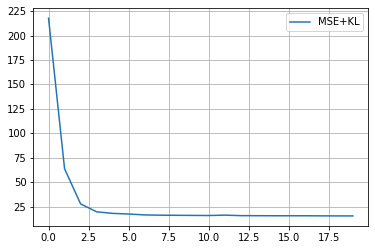

In [ ]:
if ALPHA:
  label_loss = 'MSE+KL'
else:
  label_loss= 'MSE'
plt.plot(VAE.history.history['loss'],label=label_loss)
plt.legend()
plt.grid(True)

45463
(64, 64, 3)


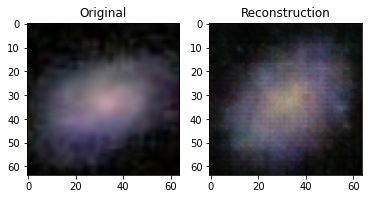

In [ ]:
# plot original and reconstruced images from test set
i = np.random.choice(len(x_train))
print(i)
x = x_train[i]
y = labels_train[i]
print(x.shape)
x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
if colors ==3:
  plt.imshow(x)
else:
  plt.imshow(x.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Original")
plt.subplot(1,2,2)
if colors ==3:
  plt.imshow(x_hat.reshape(img_dim,img_dim,colors))
else:
  plt.imshow(x_hat.reshape(img_dim,img_dim), cmap='gray')
plt.grid(False)
plt.title("Reconstruction")
plt.show()

[44665 33075 28382 57461 49597 37531 25485 24464  3592 50383 57233  5909]


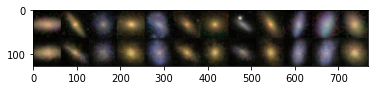

In [ ]:
d = img_dim
res = 12
flat_image = np.empty((2*d, res*d, 3))
samples = np.random.choice(len(x_train),res)
print(samples)
for i in range(res):
  x = x_train[samples[i]]
  y = labels_train[samples[i]]
  x_hat = VAE.predict([x.reshape(-1,img_dim,img_dim,colors),y.reshape(-1,labels_dim)])
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = x.reshape(img_dim,img_dim,colors)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = x_hat.reshape(img_dim,img_dim,colors)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
a = encoder.predict(x_train)

In [ ]:
a = np.asarray(a)

In [ ]:
a.shape

(2, 61578, 8)

In [ ]:
x_ind = 6
y_ind = x_ind + 1

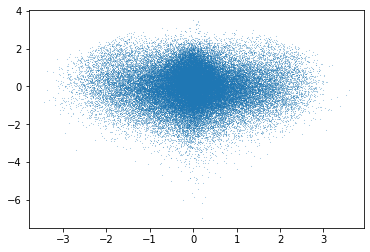

In [ ]:
m_x = a[0,:,x_ind]
#m_x = a[:,0]
m_y = a[0,:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

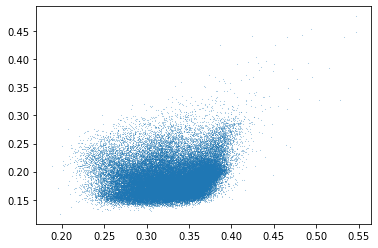

In [ ]:
s_x = a[1,:,x_ind]
s_y = a[1,:,y_ind]
plt.plot(s_x,s_y,'*',markersize=0.1)

In [ ]:
latent_stat = np.zeros((latent_dim,4))
for i in range(latent_dim):
  latent_stat[i][0] = np.mean(a[0,:,i])
  latent_stat[i][1] = np.std(a[0,:,i])
  latent_stat[i][2] = np.max(a[0,:,i])
  latent_stat[i][3] = np.min(a[0,:,i])
#latent_stat

In [ ]:
latent_stat.shape

(8, 4)

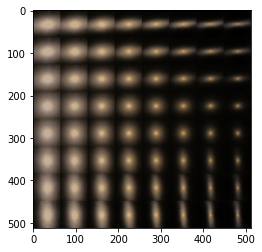

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 6
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    #random_latent = np.zeros((1,latent_dim))
    random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)
    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    random_sample = decoder.predict(random_latent)
    #random_sample = decoder.predict(np.array([latent_stat[0,0],latent_stat[1,0],center_x,center_y]).reshape(-1,latent_dim))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
#cc = decoder.predict(np.array([1,1]).reshape(-1,2))


In [ ]:
x_enc = a[0,:,:]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=latent_dim,svd_solver ="full")
pca.fit(x_enc)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [ ]:
x_enc_trans = pca.transform(x_enc)
x_enc_hat = pca.inverse_transform(x_enc_trans)

In [ ]:
np.linalg.norm(x_enc - x_enc_hat)

0.00024167926

In [ ]:
x_enc_trans.shape

(61578, 8)

In [ ]:
pca.explained_variance_ratio_

array([2.5310370e-01, 2.2244810e-01, 2.0950554e-01, 1.5956390e-01,
       1.1207318e-01, 4.2828392e-02, 2.7161901e-04, 2.0564931e-04],
      dtype=float32)

In [ ]:
pca.explained_variance_

array([1.0335034e+00, 9.0832680e-01, 8.5547823e-01, 6.5155047e-01,
       4.5763069e-01, 1.7488204e-01, 1.1091074e-03, 8.3973195e-04],
      dtype=float32)

In [ ]:
pca.singular_values_

array([252.26978, 236.49956, 229.5164 , 200.30109, 167.86758, 103.7724 ,
         8.26411,   7.19084], dtype=float32)

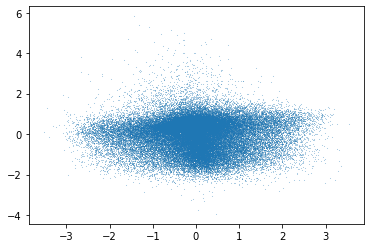

In [ ]:
x_ind = 2
y_ind = x_ind + 1
m_x = x_enc_trans[:,x_ind]
#m_x = a[:,0]
m_y = x_enc_trans[:,y_ind]
#m_y = a[:,1]
plt.plot(m_x,m_y,'*',markersize=0.1)

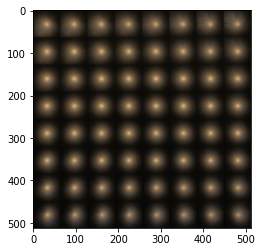

In [ ]:
d = 64
res = 8
flat_image = np.empty((res*d, res*d, 3))
x_ind = 4
y_ind = x_ind + 1
scale = 1
x_init = -3*scale
y_init = -3*scale
step_x = 2*abs(x_init)/(res-1)
step_y = 2*abs(y_init)/(res-1)
for i in range(res):
  for j in range(res):
    center_x = x_init +i*step_x
    center_y = y_init +j*step_y
    random_latent = np.zeros((1,latent_dim))
    #random_latent = np.array(latent_stat[:,0]).reshape(-1,latent_dim)

    random_latent = pca.transform(random_latent)

    random_latent[0,x_ind] = center_x
    random_latent[0,y_ind] = center_y
    #random_sample = decoder.predict(random_latent)
    random_sample = decoder.predict(pca.inverse_transform(random_latent))
    random_sample.reshape(64,64,3)
    flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = random_sample
plt.imshow(flat_image)
plt.grid(False)

## Interpolation

In [ ]:
from scipy.stats import norm

def lerp(val, low, high):
    """Linear interpolation"""
    return low + (high - low) * val

def lerp_gaussian(val, low, high):
    """Linear interpolation with gaussian CDF"""
    low_gau = norm.cdf(low)
    high_gau = norm.cdf(high)
    lerped_gau = lerp(val, low_gau, high_gau)
    return norm.ppf(lerped_gau)

def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

def slerp_gaussian(val, low, high):
    """Spherical interpolation with gaussian CDF (generally not useful)"""
    offset = norm.cdf(np.zeros_like(low))  # offset is just [0.5, 0.5, ...]
    low_gau_shifted = norm.cdf(low) - offset
    high_gau_shifted = norm.cdf(high) - offset
    circle_lerped_gau = slerp(val, low_gau_shifted, high_gau_shifted)
    epsilon = 0.001
    clipped_sum = np.clip(circle_lerped_gau + offset, epsilon, 1.0 - epsilon)
    result = norm.ppf(clipped_sum)
    return result


45514 5329


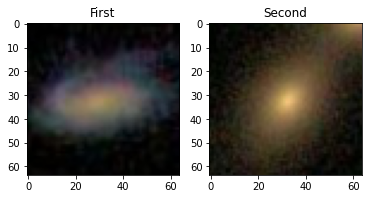

In [ ]:
#id_1 = 0
#id_2 = 9
#id_1 = np.random.choice(len(x_train))
#id_2 = np.random.choice(len(x_train))
print(id_1,id_2)
x_1 = x_train[id_1]
x_2 = x_train[id_2]
plt.figure(figsize=(6,8))
plt.subplot(1,2,1)
plt.imshow(x_1)
plt.grid(False)
plt.title("First")
plt.subplot(1,2,2)
plt.imshow(x_2)
plt.grid(False)
plt.title("Second")
plt.show()

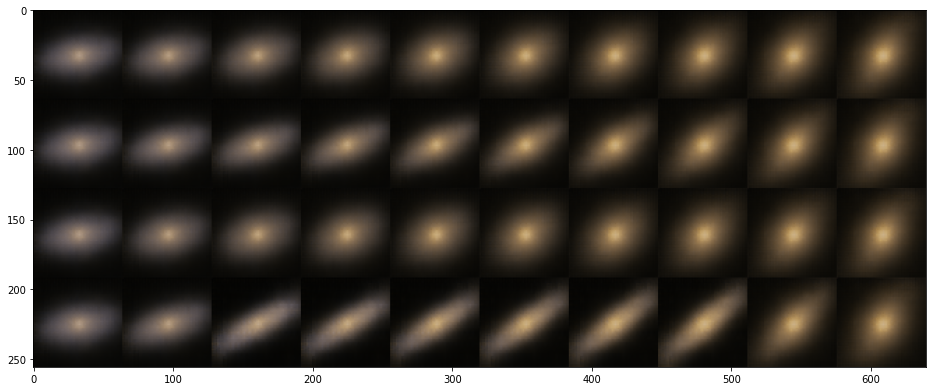

In [ ]:
## Interpolation in the latent space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
latent_1 = x_enc[id_1]
latent_2 = x_enc[id_2]
plt.figure(figsize=(16,8))
for i in range(res):
  latent_interpolate_lin = lerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_sph = slerp(i/(res-1), latent_1, latent_2)
  latent_interpolate_linG = lerp_gaussian(i/(res-1), latent_1, latent_2)
  latent_interpolate_sphG = slerp_gaussian(i/(res-1), latent_1, latent_2)
  sample_interpolate_lin = decoder.predict(latent_interpolate_lin.reshape(-1,latent_dim))
  sample_interpolate_sph = decoder.predict(latent_interpolate_sph.reshape(-1,latent_dim))
  sample_interpolate_linG = decoder.predict(latent_interpolate_linG.reshape(-1,latent_dim))
  sample_interpolate_sphG = decoder.predict(latent_interpolate_sphG.reshape(-1,latent_dim))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

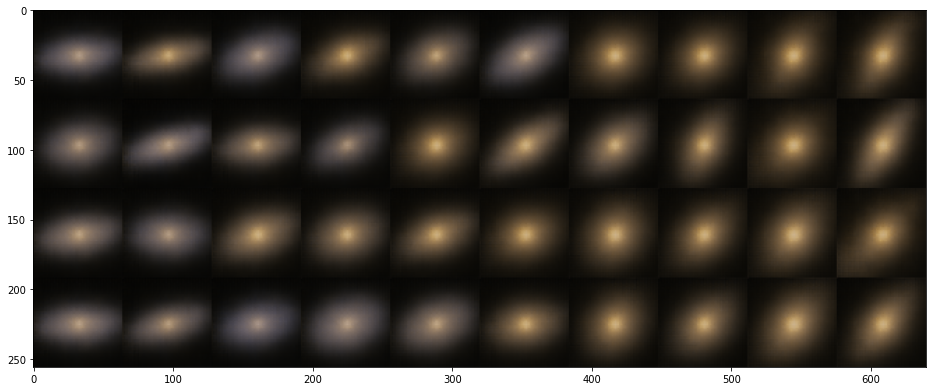

In [ ]:
## Interpolation in the input space
d = 64
res = 10
flat_image = np.empty((4*d, res*d, 3))
x_1 = x_1.ravel()
x_2 = x_2.ravel()
# original 3d dim or faltten or ravel or reshape?? why the difference between all (because of the randomness in VAE not the diffrence in reshape funcitons)
plt.figure(figsize=(16,8))
for i in range(res):
  input_interpolate_lin = lerp(i/(res-1), x_1, x_2)
  input_interpolate_sph = slerp(i/(res-1), x_1, x_2)
  input_interpolate_linG = lerp_gaussian(i/(res-1), x_1, x_2)
  input_interpolate_sphG = slerp_gaussian(i/(res-1), x_1, x_2)
  sample_input_interpolate_lin = VAE.predict(input_interpolate_lin.reshape(-1,64,64,3))
  sample_input_interpolate_sph = VAE.predict(input_interpolate_sph.reshape(-1,64,64,3))
  sample_input_interpolate_linG = VAE.predict(input_interpolate_linG.reshape(-1,64,64,3))
  sample_input_interpolate_sphG = VAE.predict(input_interpolate_sphG.reshape(-1,64,64,3))
  flat_image[0*d:(0+1)*d, i*d:(i+1)*d] = sample_input_interpolate_lin.reshape(64,64,3)
  flat_image[1*d:(1+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sph.reshape(64,64,3)
  flat_image[2*d:(2+1)*d, i*d:(i+1)*d] = sample_input_interpolate_linG.reshape(64,64,3)
  flat_image[3*d:(3+1)*d, i*d:(i+1)*d] = sample_input_interpolate_sphG.reshape(64,64,3)
plt.imshow(flat_image)
plt.grid(False)

In [ ]:
from sklearn.cluster import KMeans
n_clustres = 4
kmeans = KMeans(n_clusters=n_clustres, random_state=0).fit(x_enc)

In [ ]:
centroids = kmeans.cluster_centers_
centroids

In [ ]:
plt.plot(m_x,m_y,'*',markersize=0.1)
for center in centroids:
  plt.plot(center[0],center[1],'o', markersize=5)


In [ ]:
labels = kmeans.labels_
labels

In [ ]:
indices = list(np.arange(n_clustres))
for i in range(n_clustres):
  indices[i] = np.where(labels == i)

In [ ]:
indices

In [ ]:
# plot cluster images
cluster = 3
print("Cluster: ",cluster)
print(centroids[cluster])
samples = np.random.choice(np.asarray(indices[cluster]).ravel(),10)
print(samples)
for i, sample in enumerate(samples):
  x = x_train[sample]
  plt.subplot(2,5,i+1)
  plt.imshow(x)
  plt.grid(False)

In [ ]:
for i, sample in enumerate(samples):
  x = x_train[sample]
  x_hat = VAE.predict(x.reshape(-1,64,64,3))
  plt.subplot(2,5,i+1)
  plt.imshow(x_hat.reshape(64, 64,3))
  plt.grid(False)

In [ ]:
aa = np.random.choice(30,12)

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa.reshape((1,2,2,3))

array([[[[13, 22, 19],
         [ 8,  4, 12]],

        [[14, 28, 29],
         [ 9, 28,  6]]]])

In [ ]:
aa_f = aa.flatten()
aa_f

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa_r = aa.ravel()
aa_r

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
aa

array([13, 22, 19,  8,  4, 12, 14, 28, 29,  9, 28,  6])

In [ ]:
x_1.shape

(64, 64, 3)

In [ ]:
x_1[0].shape

(64, 3)

In [ ]:
K.image_data_format()

'channels_last'